In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install transformers datasets seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.8 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=65d89119461ab1a060a464686436821dba1dce94e5f0a54f4d9d8921172a6289
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [ ]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("daily_dialog")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


daily_dialog.py:   0%|          | 0.00/4.85k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/7.27k [00:00<?, ?B/s]

The repository for daily_dialog contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/daily_dialog.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/11118 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
# prompt: how to explore the dataset?

print(dataset)
print(dataset['train'][0])
print(dataset['train'].features)


DatasetDict({
    train: Dataset({
        features: ['dialog', 'act', 'emotion'],
        num_rows: 11118
    })
    validation: Dataset({
        features: ['dialog', 'act', 'emotion'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['dialog', 'act', 'emotion'],
        num_rows: 1000
    })
})
{'dialog': ['Say , Jim , how about going for a few beers after dinner ? ', ' You know that is tempting but is really not good for our fitness . ', ' What do you mean ? It will help us to relax . ', " Do you really think so ? I don't . It will just make us fat and act silly . Remember last time ? ", " I guess you are right.But what shall we do ? I don't feel like sitting at home . ", ' I suggest a walk over to the gym where we can play singsong and meet some of our friends . ', " That's a good idea . I hear Mary and Sally often go there to play pingpong.Perhaps we can make a foursome with them . ", ' Sounds great to me ! If they are willing , we could ask them to go dancing

In [ ]:
from transformers import BertTokenizerFast

# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Define the label names (for dialogue acts)
label_names = dataset['train'].features['act'].feature.names
num_labels = len(label_names)

# Tokenization function
def tokenize_and_encode_labels(examples):
    # Tokenize the utterances
    # Changed 'utterances' to 'dialog' to match the dataset column name
    tokenized_inputs = tokenizer(examples['dialog'], truncation=True, padding=True, is_split_into_words=True)

    # Map dialogue act tags to integers
    labels = examples['act']
    tokenized_inputs["labels"] = labels

    return tokenized_inputs

# Apply the tokenization function
tokenized_datasets = dataset.map(tokenize_and_encode_labels, batched=True)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/11118 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
from transformers import BertForSequenceClassification, TrainingArguments, Trainer
# ipython-input-4-95c330df5089
from transformers import BertTokenizerFast

# ... (rest of the code remains the same)

# Tokenization function
def tokenize_and_encode_labels(examples):
    # Tokenize the utterances
    # Changed 'utterances' to 'dialog' to match the dataset column name
    # Added padding="max_length" and truncation=True
    tokenized_inputs = tokenizer(examples['dialog'], padding="max_length", truncation=True, is_split_into_words=True, max_length=512)

    # Map dialogue act tags to integers
    # Modified to handle list of labels: taking the first label for simplicity
    labels = [label_list[0] for label_list in examples['act']]  # Take the first label from each list
    tokenized_inputs["labels"] = labels

    return tokenized_inputs

# Apply the tokenization function
tokenized_datasets = dataset.map(tokenize_and_encode_labels, batched=True)
# Load pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

# Define training arguments
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/Nors/Dialogue Project/Results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
)

# Start training
trainer.train()

Map:   0%|          | 0/11118 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


TrainOutput(global_step=2085, training_loss=0.3162513659726516, metrics={'train_runtime': 1400.0863, 'train_samples_per_second': 23.823, 'train_steps_per_second': 1.489, 'total_flos': 8776042523744256.0, 'train_loss': 0.3162513659726516, 'epoch': 3.0})

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Define a function to compute accuracy
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    return {
        'accuracy': accuracy,
        'classification_report': classification_report(labels, preds, target_names=label_names)
    }

# Evaluate the model
results = trainer.evaluate()
print(results)


{'eval_loss': 0.42232176661491394, 'eval_runtime': 14.9577, 'eval_samples_per_second': 66.855, 'eval_steps_per_second': 4.212, 'epoch': 3.0}


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Define a function to compute accuracy
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    # Get unique labels from predictions to ensure consistency
    unique_labels = sorted(list(set(labels)))
    return {
        'accuracy': accuracy,
        'classification_report': classification_report(labels, preds, target_names=[label_names[i] for i in unique_labels], labels=unique_labels) # Filter label_names and specify labels
    }

# Evaluate the model on the test set
test_results = trainer.evaluate(tokenized_datasets["test"])

# Print the evaluation results on the test set
print("Test Set Evaluation Results:")
print(test_results)

# Generate a classification report on the test set
predictions = trainer.predict(tokenized_datasets["test"])
predicted_labels = predictions.predictions.argmax(-1)
true_labels = predictions.label_ids

# Get unique labels to filter target_names
unique_labels = sorted(list(set(true_labels)))
# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=[label_names[i] for i in unique_labels], labels=unique_labels) # Filter label_names and specify labels
print("Classification Report on Test Set:")
print(report)

Test Set Evaluation Results:
{'eval_loss': 0.4144050180912018, 'eval_runtime': 14.5963, 'eval_samples_per_second': 68.511, 'eval_steps_per_second': 4.316, 'epoch': 3.0}
Classification Report on Test Set:
              precision    recall  f1-score   support

      inform       0.88      0.84      0.86       277
    question       0.92      0.93      0.92       497
   directive       0.78      0.80      0.79       226

    accuracy                           0.88      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.88      0.88      0.88      1000



In [ ]:
# prompt: connect google drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
pip install transformers datasets torch


INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.1 MB/s eta 0:00:00


In [ ]:
# prompt: how to read the three training files into 3 dataframe, consider the first half of the first dataframe, the second half of the second dataframe and the whole samples on the third dataframe to be one dataframe

import pandas as pd
import csv
# Assuming your training files are named train1.csv, train2.csv, and train3.csv
# Replace with your actual file names if they are different

# Read the three training files into pandas DataFrames
df1 = pd.read_csv('/content/drive/MyDrive/Nors/Dialogue Project/Data/Annotated Corpus/Alexander_train.tsv', sep='\t', comment='#', header=None, names=['ID', 'Start', 'End', 'Text', 'Label'])
df2 = pd.read_csv('/content/drive/MyDrive/Nors/Dialogue Project/Data/Annotated Corpus/Kirstine_train.tsv', sep='\t', comment='#', header=None, names=['ID', 'Start', 'End', 'Text', 'Label'])
df3 = pd.read_csv('/content/drive/MyDrive/Nors/Dialogue Project/Data/Annotated Corpus/Jens_train.tsv', sep='\t', comment='#', header=None, names=['ID', 'Start', 'End', 'Text', 'Label'], quoting=csv.QUOTE_NONE)


# Consider the first half of the first DataFrame
first_half_df1 = df1.iloc[:len(df1)//2]

# Consider the second half of the second DataFrame
second_half_df2 = df2.iloc[len(df2)//2:]

# Combine the selected portions of the first two DataFrames and the entire third DataFrame
combined_df = pd.concat([first_half_df1, second_half_df2, df3], ignore_index=True)

# Print the combined DataFrame
print(combined_df)


          ID        Start       End    Text  Label
0        1-1          0-5     Fader    O[1]    NaN
1        1-2         6-14  fortalte    O[1]    NaN
2        1-3        15-20     hende    O[1]    NaN
3        1-4        21-25      hvor    O[1]    NaN
4        1-5        26-29       jeg    O[1]    NaN
...      ...          ...       ...     ...    ...
20945  245-5  30654-30659     lyste  O[222]    NaN
20946  245-6  30660-30666    skarpt  O[222]    NaN
20947  245-7  30667-30669        og  O[222]    NaN
20948  245-8  30670-30675     hvast  O[222]    NaN
20949  245-9  30675-30676         .  O[222]    NaN

[20950 rows x 5 columns]


In [ ]:
print(len(first_half_df1))
print(len(second_half_df2))
print(len(df3))

7208
7208
6534


In [ ]:
print(second_half_df2.head())
print(first_half_df1.tail())
print(df3.head())

         ID        Start     End     Text  Label
7208  233-2  35511-35512       —       SM    NaN
7209  233-3  35513-35518   sagde  ST[177]    NaN
7210  233-4  35519-35522     han  ST[177]    NaN
7211  233-5  35523-35525      og   O[178]    NaN
7212  233-6  35526-35532  bøjede   O[178]    NaN
          ID        Start       End     Text  Label
7203   232-7  35497-35498         ’  SP[199]    NaN
7204   232-8  35498-35499         ,  SP[199]    NaN
7205   232-9  35500-35508  Francine  SP[199]    NaN
7206  232-10  35508-35509         !  SP[199]    NaN
7207   233-1  35509-35510         «       SM    NaN
    ID  Start    End   Text  Label
0  1-1    0-1      „     SM    NaN
1  1-2    1-3     Ja  SP[1]    NaN
2  1-3    4-9  eller  SP[1]    NaN
3  1-4  10-13    Nei  SP[1]    NaN
4  1-5  13-14      !  SP[1]    NaN


In [ ]:
import pandas as pd

# # Define the path to your .tsv file
# file_path = '/content/drive/MyDrive/Nors/Dialogue Project/Data/Annotated Corpus/Alexander_train.tsv'

# # Read the .tsv file, skipping metadata lines
# df = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['ID', 'Start', 'End', 'Text', 'Label'])
df = combined_df
# Initialize a dictionary to store the text and labels by ID
data_by_id = {}

# Process each row in the DataFrame
for index, row in df.iterrows():
    # Extract the sentence ID and convert to tuple or string
    sentence_id = tuple(row['ID'].split('-')) # Convert to tuple
    # sentence_id = row['ID'].split('-')[0]  # Use only the first part as string

    # Initialize the entry if it doesn't exist
    if sentence_id not in data_by_id:
        data_by_id[sentence_id] = {'text': "", 'labels': []}

    # Append the text and label to the corresponding entry
    data_by_id[sentence_id]['text'] += row['End'] + " "
    data_by_id[sentence_id]['labels'].append(row['Text'])

# Print the results
# for sentence_id, content in data_by_id.items():
#     print(f"ID: {sentence_id}")
#     print(f"Text: {content['text'].strip()}")
#     print(f"Labels: {content['labels']}")
#     print()

print(data_by_id)

{('1', '1'): {'text': 'Fader „ ', 'labels': ['O[1]', 'SM']}, ('1', '2'): {'text': 'fortalte Ja ', 'labels': ['O[1]', 'SP[1]']}, ('1', '3'): {'text': 'hende eller ', 'labels': ['O[1]', 'SP[1]']}, ('1', '4'): {'text': 'hvor Nei ', 'labels': ['O[1]', 'SP[1]']}, ('1', '5'): {'text': 'jeg ! ', 'labels': ['O[1]', 'SP[1]']}, ('1', '6'): {'text': 'var ', 'labels': ['O[1]']}, ('1', '7'): {'text': 'og ', 'labels': ['O[1]']}, ('1', '8'): {'text': 'endnu ', 'labels': ['O[1]']}, ('1', '9'): {'text': 'en ', 'labels': ['O[1]']}, ('1', '10'): {'text': 'Gang ', 'labels': ['O[1]']}, ('1', '11'): {'text': 'sagde ', 'labels': ['ST[2]']}, ('1', '12'): {'text': 'han ', 'labels': ['ST[2]']}, ('1', '13'): {'text': ': ', 'labels': ['SM']}, ('1', '14'): {'text': '„ ', 'labels': ['SM']}, ('1', '15'): {'text': 'Gav ', 'labels': ['SP[3]']}, ('1', '16'): {'text': 'jeg ', 'labels': ['SP[3]']}, ('1', '17'): {'text': 'Dig ', 'labels': ['SP[3]']}, ('1', '18'): {'text': 'ikke ', 'labels': ['SP[3]']}, ('1', '19'): {'text

In [ ]:
# prompt: How to group texts and labels by the sentence_id (the number before the '-')?
import re
# Initialize a dictionary to store the text and labels by ID
data_by_id = {}

# Process each row in the DataFrame
for index, row in df.iterrows():
    # Extract the sentence ID and convert to tuple or string
    sentence_id = int(row['ID'].split('-')[0])  # Use only the first part as integer

    # Initialize the entry if it doesn't exist
    if sentence_id not in data_by_id:
        data_by_id[sentence_id] = {'text': [], 'labels': []}

    # Append the text and label to the corresponding entry
    data_by_id[sentence_id]['text'].append(row['End'])
    data_by_id[sentence_id]['labels'].append(re.sub(r"\[\d+\]", "", row['Text']))

# Print the results
# for sentence_id, content in data_by_id.items():
#     print(f"ID: {sentence_id}")
#     print(f"Text: {content['text']}")
#     print(f"Labels: {content['labels']}")
#     print()
print(data_by_id)


{1: {'text': ['Fader', 'fortalte', 'hende', 'hvor', 'jeg', 'var', 'og', 'endnu', 'en', 'Gang', 'sagde', 'han', ':', '„', 'Gav', 'jeg', 'Dig', 'ikke', 'Nøglen', 'til', 'Døren', '?', '„', 'Ja', 'eller', 'Nei', '!'], 'labels': ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'ST', 'ST', 'SM', 'SM', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SM', 'SP', 'SP', 'SP', 'SP']}, 2: {'text': ['“', '„', 'Jo', '—', 'men', 'hvorfor', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '“', 'Laura', 'afbrød', 'hende', 'og', 'sagde', ':', '«', 'Ærer', 'min', 'Broder', 'ikke', 'sine', 'Forældre', ',', 'uagtet', 'han', 'rejste', 'til', 'Amerika', '?', 'De', 'gjætter', 'vel', 'hvem', 'jeg', 'sigter', 'til', '?'], 'labels': ['SM', 'SM', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SM', 'ST', 'ST', 'O', 'O', 'ST', 'SM', 'SM', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP']},

In [ ]:
# prompt: how to convert the keys and values from data_by_id into two lists: text and labels

texts = []
labels = []

for sentence_id, content in data_by_id.items():
  texts.append(content['text'])
  labels.append(content['labels'])

print(texts)
print(labels)

[['Fader', 'fortalte', 'hende', 'hvor', 'jeg', 'var', 'og', 'endnu', 'en', 'Gang', 'sagde', 'han', ':', '„', 'Gav', 'jeg', 'Dig', 'ikke', 'Nøglen', 'til', 'Døren', '?', '„', 'Ja', 'eller', 'Nei', '!'], ['“', '„', 'Jo', '—', 'men', 'hvorfor', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '“', 'Laura', 'afbrød', 'hende', 'og', 'sagde', ':', '«', 'Ærer', 'min', 'Broder', 'ikke', 'sine', 'Forældre', ',', 'uagtet', 'han', 'rejste', 'til', 'Amerika', '?', 'De', 'gjætter', 'vel', 'hvem', 'jeg', 'sigter', 'til', '?'], ['Hvorfor', 'gjælder', 'Skriften', 'anderledes', 'for', 'ham', 'end', 'for', 'mig', '?', 'Hvis', 'det', 'forholder', 'sig', 'saaledes', ',', 'saa', 'svar', 'mig', 'oprigtigt', ',', 'og', 'jeg', 'skal', 'forklare', 'mig', 'nøiere', '.', '“', '„', 'Nuvel', '!'], ['Jeg', 'har', 'samme', 'Ret', 'til', 'Livet', 'som', 'han', ',', 'og', 'jeg', 'vil', 'tage', 'mig', 'denne', 'Ret', 'trods', 'alle', 'Skriftsteder', '.', '»', 'Vreden', 'veg', 'bort', 'fra', 'Moder', 'og', 'gik', 

In [ ]:
# Flatten the list of lists before converting to a set
flattened_labels = [label for sublist in labels for label in sublist]
unique_labels = set(flattened_labels)
print(unique_labels)

# Alternative using itertools.chain.from_iterable for flattening
# import itertools
# unique_labels = set(itertools.chain.from_iterable(labels))
# print(unique_labels)

{'_', 'SP', 'SM', 'O', 'O|O', 'SP|SM', 'O|ST', 'ST'}


In [ ]:
# prompt: concatenate tokens in the inner lists to be sentences

new_texts = []
for text_list in texts:
  l = []
  sentence = " ".join(text_list)
  l.append(sentence)
  new_texts.append(l)

print(new_texts)
print(labels)

[['Fader fortalte hende hvor jeg var og endnu en Gang sagde han : „ Gav jeg Dig ikke Nøglen til Døren ? „ Ja eller Nei !'], ['“ „ Jo — men hvorfor - - - - - - - - - - - “ Laura afbrød hende og sagde : « Ærer min Broder ikke sine Forældre , uagtet han rejste til Amerika ? De gjætter vel hvem jeg sigter til ?'], ['Hvorfor gjælder Skriften anderledes for ham end for mig ? Hvis det forholder sig saaledes , saa svar mig oprigtigt , og jeg skal forklare mig nøiere . “ „ Nuvel !'], ['Jeg har samme Ret til Livet som han , og jeg vil tage mig denne Ret trods alle Skriftsteder . » Vreden veg bort fra Moder og gik over til Forfærdelse ; hun saa hurtig hen paa mig , jeg troer , hun ønskede , jeg ikke havde været tilstede , og hun sagde , idet hun ligesom flyttede sig lidt bort fra Laura : « Tag Dig iagt , Laura , for Dit eget Sind og de Tanker , Du ruger over . » Jeg stod lidt henne i Stuen , jeg var ligefrem ængstelig tilmode . ja , jeg har en saadan , som De omtaler , og det een , som jeg kan fr

In [ ]:
!pip install datasets


In [ ]:
from transformers import AutoTokenizer
from datasets import Dataset
texts = new_texts

# tokenizer = AutoTokenizer.from_pretrained('vesteinn/DanskBERT')
tokenizer = AutoTokenizer.from_pretrained('MiMe-MeMo/MeMo-BERT-03')
# tokenizer = AutoTokenizer.from_pretrained('NbAiLab/nb-bert-base')
# tokenizer = AutoTokenizer.from_pretrained('KennethEnevoldsen/dfm-sentence-encoder-large-exp2-no-lang-align')

# Define the label map
label_map = {'O': 0, 'ST': 1, 'SM': 2, 'SP': 3, '_': 4, 'O|ST':5,'O|O':6, 'SP|SM': 7}
num_labels = len(label_map)

# Tokenization and label alignment function
def tokenize_at_word_level(examples):
    tokenized_inputs = {
        "input_ids": [],  # Here we store the token IDs
        "labels": []      # We will align the labels manually
    }

    # Iterate through each example in the dataset
    for text, labels in zip(examples['text'], examples['labels']):
        # Manually split the text by spaces (to get word-level tokens)
        words = text[0].split()  # [0] because text is inside a list

        input_ids = []
        aligned_labels = []

        # Process each word independently
        for word, label in zip(words, labels):
            # Get the token ID for the whole word (without sub-word tokenization)
            word_token_id = tokenizer.encode(word, add_special_tokens=False)  # Ensure no special tokens
            # print(word_token_id)
            # Only keep the first token ID if the tokenizer splits the word
            input_ids.extend(word_token_id)  # Extend in case word maps to multiple tokens
            aligned_labels.extend([label_map[label]] * len(word_token_id))  # Align labels

        # Add the tokenized words and aligned labels to the output
        tokenized_inputs["input_ids"].append(input_ids)
        tokenized_inputs["labels"].append(aligned_labels)

    return tokenized_inputs


# Convert new_texts to a Dataset with a 'text' column
dataset = Dataset.from_dict({'text': new_texts, 'labels': labels})

# Apply the tokenization function
tokenized_datasets = dataset.map(tokenize_at_word_level, batched=True)
# print(dataset['text'])

# print(dataset['labels'])



/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/479 [00:00<?, ? examples/s]

In [ ]:
# prompt: remove the sample with labels: 5, 6 and 7 from the dataset

def filter_labels(example):
  labels = example['labels']
  return not any(label in [5, 6, 7] for label in labels)

filtered_dataset = tokenized_datasets.filter(filter_labels)
print(filtered_dataset)


Filter:   0%|          | 0/479 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'labels', 'input_ids'],
    num_rows: 475
})


In [ ]:
tokenized_datasets = filtered_dataset
print(tokenized_datasets['input_ids'])
print(tokenized_datasets['labels'])

[[6463, 2883, 353, 216, 60, 117, 33, 821, 45, 5330, 631, 133, 659, 5492, 11902, 60, 3303, 58, 31967, 52, 9735, 1355, 5492, 430, 220, 19592, 2232], [3292, 5492, 864, 3565, 121, 1095, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 3292, 12940, 26948, 353, 33, 631, 659, 981, 2157, 814, 150, 11657, 58, 1121, 18667, 200, 22909, 133, 6001, 52, 9765, 1355, 300, 498, 3564, 614, 1223, 60, 15396, 52, 1355], [983, 498, 1650, 46608, 3235, 38, 281, 279, 38, 163, 1355, 537, 39, 10291, 183, 8338, 200, 971, 861, 163, 20912, 200, 33, 60, 142, 3671, 163, 25856, 6471, 242, 3292, 5492, 35086, 2232], [101, 70, 604, 3808, 52, 6242, 99, 133, 200, 33, 60, 120, 602, 163, 473, 3808, 2177, 338, 14501, 10650, 242, 694, 131, 35057, 23963, 2442, 182, 7146, 33, 796, 185, 52, 39312, 201, 3858, 240, 971, 2402, 522, 848, 163, 200, 60, 16050, 200, 240, 3966, 200, 60, 58, 293, 416, 7907, 200, 33, 240, 631, 200, 2530, 240, 1486, 4803, 183, 344, 2442, 182, 12940, 659, 981, 2002, 3303, 13312, 200, 12940, 200, 38, 4894, 2540, 9

In [ ]:
# prompt: how to divide the tokenized_datasets into training and validation with 80% and 20%

from datasets import DatasetDict

# Split the dataset into training and validation sets (80% train, 20% validation)
train_validation_datasets = tokenized_datasets.train_test_split(test_size=0.2)

# Create a DatasetDict to store the split datasets
datasets = DatasetDict({
    'train': train_validation_datasets['train'],
    'validation': train_validation_datasets['test']
})

print(datasets)


DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids'],
        num_rows: 380
    })
    validation: Dataset({
        features: ['text', 'labels', 'input_ids'],
        num_rows: 95
    })
})


In [ ]:
# Load the pre-trained BERT model for token classification
# model = BertForTokenClassification.from_pretrained('vesteinn/DanskBERT', num_labels=5)
model = BertForTokenClassification.from_pretrained('MiMe-MeMo/MeMo-BERT-03', num_labels=num_labels)
# model = BertForTokenClassification.from_pretrained('NbAiLab/nb-bert-base', num_labels=5)
# model = BertForTokenClassification.from_pretrained('KennethEnevoldsen/dfm-sentence-encoder-large-exp2-no-lang-align', num_labels=5)

You are using a model of type xlm-roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at MiMe-MeMo/MeMo-BERT-03 and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encode

In [ ]:
from sklearn.metrics import f1_score
import numpy as np
from transformers import DataCollatorForTokenClassification
from transformers import BertTokenizerFast, BertForTokenClassification
from datasets import Dataset
import torch
from torch.utils.data import DataLoader
from transformers import AdamW
from transformers import DataCollatorForTokenClassification
from transformers import TrainingArguments, Trainer


# Define the data collator to handle padding
data_collator = DataCollatorForTokenClassification(tokenizer)
# tokenized_datasets = dataset.map(tokenize_at_word_level, batched=True)

# Define training arguments
training_args = TrainingArguments(
    # output_dir="/content/drive/MyDrive/Nors/Dialogue Project/Models/danskbert",
    # output_dir="/content/drive/MyDrive/Nors/Dialogue Project/Models/nbbert",
    # output_dir="/content/drive/MyDrive/Nors/Dialogue Project/Models/dfm",
    # output_dir="/content/drive/MyDrive/Nors/Dialogue Project/Models/memo3",
    output_dir="/content/drive/MyDrive/Nors/Dialogue Project/Models/try",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    metric_for_best_model='f1',
)

# Define the compute_metrics function

def compute_metrics(p):
    predictions, labels = p
    # print(len(predictions[0]))
    # print(len(labels[0]) )
    print(p)
    predictions = np.argmax(predictions, axis=2)

    # Flatten the predictions and labels
    true_predictions = [
        p for prediction_list in predictions for p in prediction_list
    ]
    true_labels = [
        l for label_list in labels for l in label_list
    ]

    # print("true_predictions:", true_predictions)
    # print("true_labels (from compute_metrics):", true_labels)
    # print("labels (from dataset):", dataset['labels']) # Access labels from your dataset
    # Calculate the F1 score
    f1 = f1_score(true_labels, true_predictions, average='weighted')

    return {
        'f1': f1,
    }

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=datasets['train'],  # Use datasets['train']
    eval_dataset=datasets['validation'],  # Use datasets['validation']
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Fine-tune the model
trainer.train()


TrainOutput(global_step=48, training_loss=0.40947508811950684, metrics={'train_runtime': 31.7172, 'train_samples_per_second': 23.962, 'train_steps_per_second': 1.513, 'total_flos': 56294132193600.0, 'train_loss': 0.40947508811950684, 'epoch': 2.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.299453467130661,
 'eval_f1': 0.04700246139988624,
 'eval_runtime': 3.2075,
 'eval_samples_per_second': 29.618,
 'eval_steps_per_second': 1.871,
 'epoch': 10.0}

**End of Training**

In [ ]:
import pandas as pd

# Define the path to your .tsv file
file_path = '/content/drive/MyDrive/Nors/Dialogue Project/Data/Annotated Corpus/Alexander_test.tsv'

# Read the .tsv file, skipping metadata lines
df_test = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=['ID', 'Start', 'End', 'Text', 'Label'])

# Display the DataFrame
print(df_test)


          ID        Start             End   Text  Label
0        1-1          0-5           Helga   O[1]    NaN
1        1-2          5-6               ,   O[1]    NaN
2        1-3         7-10             som   O[1]    NaN
3        1-4        11-16           siden   O[1]    NaN
4        1-5        17-31  Morgenstundens   O[1]    NaN
...      ...          ...             ...    ...    ...
2525  128-30  11691-11700       alvorligt  O[95]    NaN
2526  128-31  11701-11703              og  O[95]    NaN
2527  128-32  11704-11713       forskende  O[95]    NaN
2528  128-33  11714-11718            Blik  O[95]    NaN
2529  128-34  11718-11719               .  O[95]    NaN

[2530 rows x 5 columns]


In [ ]:
# Initialize a dictionary to store the text and labels by ID
data_by_id = {}

# Process each row in the DataFrame
for index, row in df_test.iterrows():
    # Extract the sentence ID and convert to tuple or string
    sentence_id = tuple(row['ID'].split('-')) # Convert to tuple
    # sentence_id = row['ID'].split('-')[0]  # Use only the first part as string

    # Initialize the entry if it doesn't exist
    if sentence_id not in data_by_id:
        data_by_id[sentence_id] = {'text': "", 'labels': []}

    # Append the text and label to the corresponding entry
    data_by_id[sentence_id]['text'] += row['End'] + " "
    data_by_id[sentence_id]['labels'].append(row['Text'])

# Print the results
# for sentence_id, content in data_by_id.items():
#     print(f"ID: {sentence_id}")
#     print(f"Text: {content['text'].strip()}")
#     print(f"Labels: {content['labels']}")
#     print()

print(data_by_id)

{('1', '1'): {'text': 'Helga ', 'labels': ['O[1]']}, ('1', '2'): {'text': ', ', 'labels': ['O[1]']}, ('1', '3'): {'text': 'som ', 'labels': ['O[1]']}, ('1', '4'): {'text': 'siden ', 'labels': ['O[1]']}, ('1', '5'): {'text': 'Morgenstundens ', 'labels': ['O[1]']}, ('1', '6'): {'text': 'Drøm ', 'labels': ['O[1]']}, ('1', '7'): {'text': 'havde ', 'labels': ['O[1]']}, ('1', '8'): {'text': 'haft ', 'labels': ['O[1]']}, ('1', '9'): {'text': 'en ', 'labels': ['O[1]']}, ('1', '10'): {'text': 'dunkel ', 'labels': ['O[1]']}, ('1', '11'): {'text': 'Anelse ', 'labels': ['O[1]']}, ('1', '12'): {'text': 'om ', 'labels': ['O[1]']}, ('1', '13'): {'text': ', ', 'labels': ['O[1]']}, ('1', '14'): {'text': 'hvad ', 'labels': ['O[1]']}, ('1', '15'): {'text': 'der ', 'labels': ['O[1]']}, ('1', '16'): {'text': 'vilde ', 'labels': ['O[1]']}, ('1', '17'): {'text': 'ske ', 'labels': ['O[1]']}, ('1', '18'): {'text': ', ', 'labels': ['O[1]']}, ('1', '19'): {'text': 'var ', 'labels': ['O[1]']}, ('1', '20'): {'text

In [ ]:
# prompt: How to group texts and labels by the sentence_id (the number before the '-')?
import re
# Initialize a dictionary to store the text and labels by ID
data_by_id = {}

# Process each row in the DataFrame
for index, row in df_test.iterrows():
    # Extract the sentence ID and convert to tuple or string
    sentence_id = int(row['ID'].split('-')[0])  # Use only the first part as integer

    # Initialize the entry if it doesn't exist
    if sentence_id not in data_by_id:
        data_by_id[sentence_id] = {'text': [], 'labels': []}

    # Append the text and label to the corresponding entry
    data_by_id[sentence_id]['text'].append(row['End'])
    data_by_id[sentence_id]['labels'].append(re.sub(r"\[\d+\]", "", row['Text']))

# Print the results
# for sentence_id, content in data_by_id.items():
#     print(f"ID: {sentence_id}")
#     print(f"Text: {content['text']}")
#     print(f"Labels: {content['labels']}")
#     print()
print(data_by_id)


{1: {'text': ['Helga', ',', 'som', 'siden', 'Morgenstundens', 'Drøm', 'havde', 'haft', 'en', 'dunkel', 'Anelse', 'om', ',', 'hvad', 'der', 'vilde', 'ske', ',', 'var', 'saa', 'inderlig', 'og', 'dybt', 'bedrøvet', '.'], 'labels': ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']}, 2: {'text': ['Dagen', 'efter', 'kom', 'Familiens', 'fortvivlede', 'Breve', '.'], 'labels': ['O', 'O', 'O', 'O', 'O', 'O', 'O']}, 3: {'text': ['Marys', 'Moder', 'skrev', ',', 'at', 'hendes', 'Datter', 'bestandig', 'havde', 'talt', 'om', 'Helga', 'og', 'glædet', 'sig', 'til', 'at', 'se', 'hende', '.'], 'labels': ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']}, 4: {'text': ['Flun', 'havde', 'været', 'klar', 'indtil', 'den', 'sidste', 'Times', 'Tid', ',', 'da', 'Feberen', 'steg', 'og', 'Aandedrættet', 'blev', 'besværligt', ',', 'og', 'havde', 'formanet', 'dem', 'til', 'ikke', 'at', 'sørg

In [ ]:
# prompt: how to convert the keys and values from data_by_id into two lists: text and labels

texts = []
labels = []

for sentence_id, content in data_by_id.items():
  texts.append(content['text'])
  labels.append(content['labels'])

print(texts)
print(labels)

[['Helga', ',', 'som', 'siden', 'Morgenstundens', 'Drøm', 'havde', 'haft', 'en', 'dunkel', 'Anelse', 'om', ',', 'hvad', 'der', 'vilde', 'ske', ',', 'var', 'saa', 'inderlig', 'og', 'dybt', 'bedrøvet', '.'], ['Dagen', 'efter', 'kom', 'Familiens', 'fortvivlede', 'Breve', '.'], ['Marys', 'Moder', 'skrev', ',', 'at', 'hendes', 'Datter', 'bestandig', 'havde', 'talt', 'om', 'Helga', 'og', 'glædet', 'sig', 'til', 'at', 'se', 'hende', '.'], ['Flun', 'havde', 'været', 'klar', 'indtil', 'den', 'sidste', 'Times', 'Tid', ',', 'da', 'Feberen', 'steg', 'og', 'Aandedrættet', 'blev', 'besværligt', ',', 'og', 'havde', 'formanet', 'dem', 'til', 'ikke', 'at', 'sørge', 'over', 'hende', '.'], ['Hun', 'gik', 'saa', 'glad', 'herfra', '.'], ['Straks', 'hun', 'kom', 'til', 'Sengs', ',', 'vidste', 'hun', ',', 'at', 'det', 'blev', 'Døden', '.'], ['Hun', 'vilde', 'intet', 'høre', 'om', 'at', 'komme', 'sig', '.'], ['Fanny', 'gik', 'ugenert', 'gennem', 'Moderens', 'pæne', 'Stue', 'ind', 'i', 'Værkstedet', '.'], ['He

In [ ]:
# prompt: concatenate tokens in the inner lists to be sentences
# Flatten the list of lists before converting to a set
flattened_labels = [label for sublist in labels for label in sublist]
unique_labels = set(flattened_labels)
print(unique_labels)



{'ST', 'O', 'SP', 'SM', '_'}


In [ ]:
# Alternative using itertools.chain.from_iterable for flattening
# import itertools
# unique_labels = set(itertools.chain.from_iterable(labels))
# print(unique_labels)
new_texts = []
for text_list in texts:
  l = []
  sentence = " ".join(text_list)
  l.append(sentence)
  new_texts.append(l)

print(new_texts)
print(labels)

[['Helga , som siden Morgenstundens Drøm havde haft en dunkel Anelse om , hvad der vilde ske , var saa inderlig og dybt bedrøvet .'], ['Dagen efter kom Familiens fortvivlede Breve .'], ['Marys Moder skrev , at hendes Datter bestandig havde talt om Helga og glædet sig til at se hende .'], ['Flun havde været klar indtil den sidste Times Tid , da Feberen steg og Aandedrættet blev besværligt , og havde formanet dem til ikke at sørge over hende .'], ['Hun gik saa glad herfra .'], ['Straks hun kom til Sengs , vidste hun , at det blev Døden .'], ['Hun vilde intet høre om at komme sig .'], ['Fanny gik ugenert gennem Moderens pæne Stue ind i Værkstedet .'], ['Her stod hun lidt stille og snusede Luft til sig , idet hun sagde : Jeg kan saa godt lide Skomagerlugt .'], ['Og sikke nogle dejlige Blomster De har .'], ['At de kan trives her !'], ['Vil De ikke sidde ned ?'], ['spurgte Frederik og pegede paa Sengekanten , Stuens eneste magelige Sæde .'], ['Hvad dette her skulde ende med , vidste han ikke

In [ ]:
# prompt: how to store predicted_labels_readable as a single list not list of lists

# Load the saved model and tokenizer
model = BertForTokenClassification.from_pretrained('/content/drive/MyDrive/Nors/Dialogue Project/Models3/checkpoint-300')  # Path to the fine-tuned model
# tokenizer = BertTokenizerFast.from_pretrained('MiMe-MeMo/MeMo-BERT-03')
tokenizer = AutoTokenizer.from_pretrained('vesteinn/DanskBERT')
# Example new text for prediction


def tokenize_at_word_level_for_prediction(examples,labels):
    tokenized_inputs = {
        "input_ids": [],
        "attention_mask": []
    }
    extended_labels = []
    for text, label in zip(examples,labels):
        # words = text[0].split()
        tokens = []
        for word in text[0].split():
          current_token = ""
          for char in word:
            if char.isalnum():
              current_token += char
            else:
              if current_token:
                tokens.append(current_token)
                current_token = ""
              tokens.append(char)
          if current_token:
            tokens.append(current_token)
        words = tokens
        # print(len(words))
        # print(words)
        input_ids = []
        attention_mask = []
        # print(words)
        for word,label in zip(words,label):
            # print(word)
            # print(label)
            word_token_id = tokenizer.encode(word, add_special_tokens=False)
            # print(len(word_token_id))
            input_ids.extend(word_token_id)
            for i in range(len(word_token_id)):
              extended_labels.append(label)
            attention_mask.extend([1] * len(word_token_id))
        # print(len(attention_mask))
        # print(extended_labels)
        # print(len(extended_labels))
        tokenized_inputs["input_ids"].append(input_ids)
        tokenized_inputs["attention_mask"].append(attention_mask)

    return tokenized_inputs, extended_labels

a_labels = []
p_labels = []
# Tokenize the new text
for text, label in zip(new_texts, labels):
  # print(text)
  tokenized_new_texts,actual_labels = tokenize_at_word_level_for_prediction([text],[label]) #Modified line
  # print(tokenized_new_texts)
  # Convert tokenized_new_texts to tensors and move to the device
  input_ids = torch.tensor(tokenized_new_texts['input_ids'])
  attention_mask = torch.tensor(tokenized_new_texts['attention_mask'])

  # Make predictions
  with torch.no_grad():
      outputs = model(input_ids=input_ids, attention_mask=attention_mask)

  # Get predicted labels
  predicted_labels = torch.argmax(outputs.logits, dim=2).numpy()

  # Inverse label mapping
  label_map_reverse = {v: k for k, v in label_map.items()}
  predicted_labels_readable = [label_map_reverse[label] for label_list in predicted_labels for label in label_list] # Flatten the list of lists

  # Print the predictions
  # print("Predicted Labels:")
  # print(predicted_labels_readable)
  # print(len(predicted_labels_readable))

  # print(actual_labels)
  # print(len(actual_labels))
  a_labels.append(actual_labels)
  p_labels.append(predicted_labels_readable)
  # print('=======================')

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
from sklearn.metrics import f1_score

# Given predicted and actual labels (list of lists)
predicted_labels = p_labels
actual_labels = a_labels

# Define the label map
label_map = {'O': 0, 'ST': 1, 'SM': 2, 'SP': 3, '_': 4}

# Flatten the list of lists and convert labels to numerical values
predicted_labels_flat = [label_map[label] for sublist in predicted_labels for label in sublist]
actual_labels_flat = [label_map[label] for sublist in actual_labels for label in sublist]

# Calculate the F1 score
f1 = f1_score(actual_labels_flat, predicted_labels_flat, average='weighted')

print(f"The F1 score is: {f1}")


The F1 score is: 0.72377416820226


# IAA

In [ ]:
# prompt: how to replace all labels to be as follow on each list:
# re.sub(r"\[\d+\]", "", row['Text'])
# write it as a function

import re

def replace_labels_in_list(label_list):
  """
  Replaces labels in a list by removing bracketed numbers.

  Args:
    label_list: A list of labels.

  Returns:
    A new list with bracketed numbers removed from each label.
  """
  new_label_list = [re.sub(r"\[\d+\]", "", label) for label in label_list]
  return new_label_list


In [ ]:
# prompt: How to read 3 .tsv files to 3 dataframes and calculate the inter-annotator agreement based on one column. The data is a list of sentences and the annotation has been done on a word level.

import pandas as pd
from sklearn.metrics import cohen_kappa_score

# Paths to your .tsv files
file_path1 = '/content/drive/MyDrive/Nors/Dialogue Project/Data/Annotated Corpus/Alexander_test.tsv'
file_path2 = '/content/drive/MyDrive/Nors/Dialogue Project/Data/Annotated Corpus/Jens_test.tsv'
file_path3 = '/content/drive/MyDrive/Nors/Dialogue Project/Data/Annotated Corpus/Kirstine_test.tsv'

# Read the .tsv files into DataFrames
df1 = pd.read_csv(file_path1, sep='\t', comment='#', header=None, names=['ID', 'Start', 'End', 'Text', 'Label'])
df2 = pd.read_csv(file_path2, sep='\t', comment='#', header=None, names=['ID', 'Start', 'End', 'Text', 'Label'])
df3 = pd.read_csv(file_path3, sep='\t', comment='#', header=None, names=['ID', 'Start', 'End', 'Text', 'Label'])

# Assuming you want to calculate IAA based on the 'Label' column
# You might need to preprocess the data further depending on the format
# Example:

labels1 = replace_labels_in_list(df1['Text'].tolist())
labels2 = replace_labels_in_list(df2['Text'].tolist())
labels3 = replace_labels_in_list(df3['Text'].tolist())

print(labels1)
print(labels2)
print(labels3)
# Calculate Cohen's Kappa between annotators 1 and 2
kappa12 = cohen_kappa_score(labels1, labels2)

# Calculate Cohen's Kappa between annotators 1 and 3
kappa13 = cohen_kappa_score(labels1, labels3)

# Calculate Cohen's Kappa between annotators 2 and 3
kappa23 = cohen_kappa_score(labels2, labels3)

print(f"Cohen's Kappa (Annotator 1 vs. Annotator 2): {kappa12}")
print(f"Cohen's Kappa (Annotator 1 vs. Annotator 3): {kappa13}")
print(f"Cohen's Kappa (Annotator 2 vs. Annotator 3): {kappa23}")
print()
print(f"Cohen's Kappa (Annotator 1 vs. Annotator 2 vs. Annotator 3): {(kappa12 + kappa13 + kappa23)/3}")

# You can then average these Kappa scores or use other IAA metrics as needed.


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'ST', 'ST', 'SM', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'ST', 'ST', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'ST', 'O', 'O', 'O', 'ST', 'SM', 'SP'

In [ ]:
# prompt: How to generate a new label list that contains the majority vote from the 3 labels lists

from collections import Counter

def majority_vote_labels(label_lists):
  """
  Generates a new label list that contains the majority vote from a list of label lists.

  Args:
    label_lists: A list of lists, where each inner list represents the labels from a different annotator.

  Returns:
    A new list containing the majority vote labels.
  """

  new_labels = []
  for labels in zip(*label_lists):
    label_counts = Counter(labels)
    most_common_labels = label_counts.most_common()

    if not most_common_labels:
      new_labels.append(None)  # Handle cases with no labels
    elif len(most_common_labels) == 1 or most_common_labels[0][1] > most_common_labels[1][1]:
      new_labels.append(most_common_labels[0][0])
    else:
      # In case of a tie, you can choose to:
      # 1. Use a random label from the tied ones.
      # 2. Select a default label.
      # 3. Discard the label (append None).
      new_labels.append(most_common_labels[0][0])  # Choose the first most common label for ties

  return new_labels

# Example usage:
majority_labels = majority_vote_labels([labels1, labels2, labels3])
print("Majority Vote Labels:", majority_labels)


Majority Vote Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'ST', 'ST', 'SM', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'ST', 'ST', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 

In [ ]:
len(majority_labels)


2530

In [ ]:
# prompt: print the unique values and their frequencies from majority_labels.

from collections import Counter

label_counts = Counter(majority_labels)
for label, count in label_counts.items():
  print(f"Label: {label}, Frequency: {count}")


Label: O, Frequency: 1670
Label: ST, Frequency: 49
Label: SM, Frequency: 55
Label: SP, Frequency: 755
Label: _, Frequency: 1


In [ ]:
# prompt: print the unique values and their frequencies from majority_labels. Alex

from collections import Counter

label_counts = Counter(labels1)
for label, count in label_counts.items():
  print(f"Label: {label}, Frequency: {count}")


Label: O, Frequency: 1688
Label: ST, Frequency: 46
Label: SM, Frequency: 57
Label: SP, Frequency: 737
Label: _, Frequency: 2


In [ ]:
# prompt: print the unique values and their frequencies from majority_labels. Jens

from collections import Counter

label_counts = Counter(labels2)
for label, count in label_counts.items():
  print(f"Label: {label}, Frequency: {count}")


Label: O, Frequency: 1676
Label: ST, Frequency: 47
Label: SM, Frequency: 57
Label: SP, Frequency: 744
Label: _, Frequency: 6


In [ ]:
# prompt: print the unique values and their frequencies from majority_labels. Kir

from collections import Counter

label_counts = Counter(labels3)
for label, count in label_counts.items():
  print(f"Label: {label}, Frequency: {count}")


Label: O, Frequency: 1671
Label: ST, Frequency: 48
Label: SM, Frequency: 54
Label: SP, Frequency: 685
Label: _, Frequency: 72


Testing

In [ ]:
# prompt: Read the three testing files into dataframes
# group texts and labels by the sentence_id (the number before the '-')
# convert the keys and values from data_by_id into two lists: text and labels
import re
import pandas as pd
# Paths to your .tsv files
file_path1 = '/content/drive/MyDrive/Nors/Dialogue Project/Data/Annotated Corpus/Alexander_test.tsv'
file_path2 = '/content/drive/MyDrive/Nors/Dialogue Project/Data/Annotated Corpus/Jens_test.tsv'
file_path3 = '/content/drive/MyDrive/Nors/Dialogue Project/Data/Annotated Corpus/Kirstine_test.tsv'

# Read the .tsv files into DataFrames
df1 = pd.read_csv(file_path1, sep='\t', comment='#', header=None, names=['ID', 'Start', 'End', 'Text', 'Label'])
df2 = pd.read_csv(file_path2, sep='\t', comment='#', header=None, names=['ID', 'Start', 'End', 'Text', 'Label'])
df3 = pd.read_csv(file_path3, sep='\t', comment='#', header=None, names=['ID', 'Start', 'End', 'Text', 'Label'])


def process_dataframe(df):
  data_by_id = {}
  for index, row in df.iterrows():
      sentence_id = int(row['ID'].split('-')[0])
      if sentence_id not in data_by_id:
          data_by_id[sentence_id] = {'text': [], 'labels': []}
      data_by_id[sentence_id]['text'].append(row['End'])
      data_by_id[sentence_id]['labels'].append(re.sub(r"\[\d+\]", "", row['Text']))

  texts = []
  labels = []
  for sentence_id, content in data_by_id.items():
    texts.append(content['text'])
    labels.append(content['labels'])
  return texts, labels

texts1, labels1 = process_dataframe(df1)
texts2, labels2 = process_dataframe(df2)
texts3, labels3 = process_dataframe(df3)


In [ ]:
print(texts1)
print(labels1)

[['Helga', ',', 'som', 'siden', 'Morgenstundens', 'Drøm', 'havde', 'haft', 'en', 'dunkel', 'Anelse', 'om', ',', 'hvad', 'der', 'vilde', 'ske', ',', 'var', 'saa', 'inderlig', 'og', 'dybt', 'bedrøvet', '.'], ['Dagen', 'efter', 'kom', 'Familiens', 'fortvivlede', 'Breve', '.'], ['Marys', 'Moder', 'skrev', ',', 'at', 'hendes', 'Datter', 'bestandig', 'havde', 'talt', 'om', 'Helga', 'og', 'glædet', 'sig', 'til', 'at', 'se', 'hende', '.'], ['Flun', 'havde', 'været', 'klar', 'indtil', 'den', 'sidste', 'Times', 'Tid', ',', 'da', 'Feberen', 'steg', 'og', 'Aandedrættet', 'blev', 'besværligt', ',', 'og', 'havde', 'formanet', 'dem', 'til', 'ikke', 'at', 'sørge', 'over', 'hende', '.'], ['Hun', 'gik', 'saa', 'glad', 'herfra', '.'], ['Straks', 'hun', 'kom', 'til', 'Sengs', ',', 'vidste', 'hun', ',', 'at', 'det', 'blev', 'Døden', '.'], ['Hun', 'vilde', 'intet', 'høre', 'om', 'at', 'komme', 'sig', '.'], ['Fanny', 'gik', 'ugenert', 'gennem', 'Moderens', 'pæne', 'Stue', 'ind', 'i', 'Værkstedet', '.'], ['He

In [ ]:
new_texts = []
for text_list in texts1:
  l = []
  sentence = " ".join(text_list)
  l.append(sentence)
  new_texts.append(l)

print(new_texts)
print(labels1)

[['Helga , som siden Morgenstundens Drøm havde haft en dunkel Anelse om , hvad der vilde ske , var saa inderlig og dybt bedrøvet .'], ['Dagen efter kom Familiens fortvivlede Breve .'], ['Marys Moder skrev , at hendes Datter bestandig havde talt om Helga og glædet sig til at se hende .'], ['Flun havde været klar indtil den sidste Times Tid , da Feberen steg og Aandedrættet blev besværligt , og havde formanet dem til ikke at sørge over hende .'], ['Hun gik saa glad herfra .'], ['Straks hun kom til Sengs , vidste hun , at det blev Døden .'], ['Hun vilde intet høre om at komme sig .'], ['Fanny gik ugenert gennem Moderens pæne Stue ind i Værkstedet .'], ['Her stod hun lidt stille og snusede Luft til sig , idet hun sagde : Jeg kan saa godt lide Skomagerlugt .'], ['Og sikke nogle dejlige Blomster De har .'], ['At de kan trives her !'], ['Vil De ikke sidde ned ?'], ['spurgte Frederik og pegede paa Sengekanten , Stuens eneste magelige Sæde .'], ['Hvad dette her skulde ende med , vidste han ikke

In [ ]:
# prompt: calculate the inter-annotator agreement between labels1, labels2, and labels3
# generate one new label list contains the majority vote. keep the new list in majority vote same as the original one for example labels1

from sklearn.metrics import cohen_kappa_score
from collections import Counter
import re

def replace_labels_in_list(label_list):
  """Replaces labels in a list by removing bracketed numbers."""
  new_label_list = [re.sub(r"\[\d+\]", "", label) for label in label_list]
  return new_label_list

def majority_vote_labels(label_lists):
  """Generates a new label list that contains the majority vote from a list of label lists."""
  new_labels = []
  for labels in zip(*label_lists):
    label_counts = Counter(labels)
    most_common_labels = label_counts.most_common()

    if not most_common_labels:
      new_labels.append(None)
    elif len(most_common_labels) == 1 or most_common_labels[0][1] > most_common_labels[1][1]:
      new_labels.append(most_common_labels[0][0])
    else:
      new_labels.append(most_common_labels[0][0])

  return new_labels

# Flatten the lists of lists and remove bracketed numbers
flat_labels1 = [item for sublist in labels1 for item in sublist]
flat_labels2 = [item for sublist in labels2 for item in sublist]
flat_labels3 = [item for sublist in labels3 for item in sublist]

flat_labels1 = replace_labels_in_list(flat_labels1)
flat_labels2 = replace_labels_in_list(flat_labels2)
flat_labels3 = replace_labels_in_list(flat_labels3)

# Calculate Cohen's Kappa between annotators
kappa12 = cohen_kappa_score(flat_labels1, flat_labels2)
kappa13 = cohen_kappa_score(flat_labels1, flat_labels3)
kappa23 = cohen_kappa_score(flat_labels2, flat_labels3)

print(f"Cohen's Kappa (Annotator 1 vs. Annotator 2): {kappa12}")
print(f"Cohen's Kappa (Annotator 1 vs. Annotator 3): {kappa13}")
print(f"Cohen's Kappa (Annotator 2 vs. Annotator 3): {kappa23}")
print(f"Average Cohen's Kappa: {(kappa12 + kappa13 + kappa23) / 3}")


# Generate a new label list with majority vote
majority_labels = majority_vote_labels([flat_labels1, flat_labels2, flat_labels3])

# Reshape the majority labels to match the original structure of labels1
new_majority_labels = []
index = 0
for sublist in labels1:
  new_sublist = []
  for _ in sublist:
    new_sublist.append(majority_labels[index])
    index += 1
  new_majority_labels.append(new_sublist)

print("New Majority Labels:", new_majority_labels)


Cohen's Kappa (Annotator 1 vs. Annotator 2): 0.9362902207741991
Cohen's Kappa (Annotator 1 vs. Annotator 3): 0.9167648487268797
Cohen's Kappa (Annotator 2 vs. Annotator 3): 0.9015850767189061
Average Cohen's Kappa: 0.9182133820733283
New Majority Labels: [['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'ST', 'ST', 'SM', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP', 'SP'], [

# Testing

In [ ]:
!pip install transformers

In [ ]:
# prompt: how to store predicted_labels_readable as a single list not list of lists

# Import necessary libraries
from transformers import BertForTokenClassification, AutoTokenizer
import torch

# Load the saved model and tokenizer
# model = BertForTokenClassification.from_pretrained('/content/drive/MyDrive/Nors/Dialogue Project/Models/memo3/checkpoint-240')  # Path to the fine-tuned model
# model = BertForTokenClassification.from_pretrained('/content/drive/MyDrive/Nors/Dialogue Project/Models/danskbert/checkpoint-240')  # Path to the fine-tuned model
# model = BertForTokenClassification.from_pretrained('/content/drive/MyDrive/Nors/Dialogue Project/Models/nbbert/checkpoint-240')  # Path to the fine-tuned model
model = BertForTokenClassification.from_pretrained('/content/drive/MyDrive/Nors/Dialogue Project/Models/dfm/checkpoint-160')  # Path to the fine-tuned model

# tokenizer = BertTokenizerFast.from_pretrained('MiMe-MeMo/MeMo-BERT-03')
# tokenizer = AutoTokenizer.from_pretrained('vesteinn/DanskBERT')
# tokenizer = AutoTokenizer.from_pretrained('NbAiLab/nb-bert-base')
tokenizer = AutoTokenizer.from_pretrained('KennethEnevoldsen/dfm-sentence-encoder-large-exp2-no-lang-align')
# Example new text for prediction


def tokenize_at_word_level_for_prediction(examples,labels):
    tokenized_inputs = {
        "input_ids": [],
        "attention_mask": []
    }
    extended_labels = []
    for text, label in zip(examples,labels):
        # words = text[0].split()
        tokens = []
        for word in text[0].split():
          current_token = ""
          for char in word:
            if char.isalnum():
              current_token += char
            else:
              if current_token:
                tokens.append(current_token)
                current_token = ""
              tokens.append(char)
          if current_token:
            tokens.append(current_token)
        words = tokens
        # print(len(words))
        # print(words)
        input_ids = []
        attention_mask = []
        # print(words)
        for word,label in zip(words,label):
            # print(word)
            # print(label)
            word_token_id = tokenizer.encode(word, add_special_tokens=False)
            # print(len(word_token_id))
            input_ids.extend(word_token_id)
            for i in range(len(word_token_id)):
              extended_labels.append(label)
            attention_mask.extend([1] * len(word_token_id))
        # print(len(attention_mask))
        # print(extended_labels)
        # print(len(extended_labels))
        tokenized_inputs["input_ids"].append(input_ids)
        tokenized_inputs["attention_mask"].append(attention_mask)

    return tokenized_inputs, extended_labels
# Define the label map
label_map = {'O': 0, 'ST': 1, 'SM': 2, 'SP': 3, '_': 4, 'O|ST':5,'O|O':6}
num_labels = len(label_map)
a_labels = []
p_labels = []
# Tokenize the new text
for text, label in zip(new_texts, new_majority_labels):
  # print(text)
  tokenized_new_texts,actual_labels = tokenize_at_word_level_for_prediction([text],[label]) #Modified line
  # print(tokenized_new_texts)
  # Convert tokenized_new_texts to tensors and move to the device
  input_ids = torch.tensor(tokenized_new_texts['input_ids'])
  attention_mask = torch.tensor(tokenized_new_texts['attention_mask'])

  # Make predictions
  with torch.no_grad():
      outputs = model(input_ids=input_ids, attention_mask=attention_mask)

  # Get predicted labels
  predicted_labels = torch.argmax(outputs.logits, dim=2).numpy()

  # Inverse label mapping
  label_map_reverse = {v: k for k, v in label_map.items()}
  predicted_labels_readable = [label_map_reverse[label] for label_list in predicted_labels for label in label_list] # Flatten the list of lists

  # Print the predictions
  # print("Predicted Labels:")
  # print(predicted_labels_readable)
  # print(len(predicted_labels_readable))

  # print(actual_labels)
  # print(len(actual_labels))
  a_labels.append(actual_labels)
  p_labels.append(predicted_labels_readable)
  # print('=======================')

In [ ]:
from sklearn.metrics import f1_score

# Given predicted and actual labels (list of lists)
predicted_labels = p_labels
actual_labels = a_labels

# Define the label map
label_map = {'O': 0, 'ST': 1, 'SM': 2, 'SP': 3, '_': 4}

# Flatten the list of lists and convert labels to numerical values
predicted_labels_flat = [label_map[label] for sublist in predicted_labels for label in sublist]
actual_labels_flat = [label_map[label] for sublist in actual_labels for label in sublist]

# Calculate the F1 score
f1 = f1_score(actual_labels_flat, predicted_labels_flat, average='weighted')

print(f"The F1 score is: {f1}")


The F1 score is: 0.8666108664352529


In [ ]:
# prompt: print the precision and recall as well

from sklearn.metrics import precision_score, recall_score

# ... (Your existing code)


# Given predicted and actual labels (list of lists)
predicted_labels = p_labels
actual_labels = a_labels

# Define the label map
label_map = {'O': 0, 'ST': 1, 'SM': 2, 'SP': 3, '_': 4, 'O|ST':5,'O|O':6}

# Flatten the list of lists and convert labels to numerical values
predicted_labels_flat = [label_map[label] for sublist in predicted_labels for label in sublist]
actual_labels_flat = [label_map[label] for sublist in actual_labels for label in sublist]

# Calculate the F1 score
f1 = f1_score(actual_labels_flat, predicted_labels_flat, average='weighted')

#Calculate precision and recall
precision = precision_score(actual_labels_flat, predicted_labels_flat, average='weighted')
recall = recall_score(actual_labels_flat, predicted_labels_flat, average='weighted')


print(f"The F1 score is: {f1}")
print(f"The precision is: {precision}")
print(f"The recall is: {recall}")

The F1 score is: 0.8666108664352529
The precision is: 0.8727903287647246
The recall is: 0.8642929123278468


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:
[[966  51  47 784   0]
 [ 42   2   2  15   0]
 [ 31   5   4  21   0]
 [466  15  11 346   0]
 [  0   0   0   1   0]]


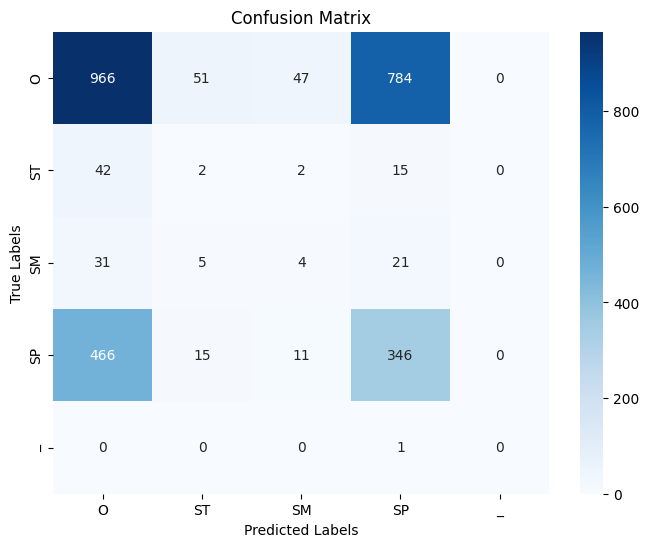

In [ ]:
# prompt: print the confusion matrix

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have predicted_labels_flat and actual_labels_flat
# from the previous code

# Calculate the confusion matrix
cm = confusion_matrix(actual_labels_flat, predicted_labels_flat)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# You can also visualize the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# prompt: print the f1-score weighted per class and number of samples

from sklearn.metrics import f1_score

# Assuming you have predicted_labels_flat and actual_labels_flat
# from the previous code

# Calculate the F1 score for each class
f1_per_class = f1_score(actual_labels_flat, predicted_labels_flat, average=None)

# Count the number of samples for each class
class_counts = Counter(actual_labels_flat)

# Print the F1 score, weighted per class, and the number of samples
for i, label in enumerate(label_map.keys()):
  print(f"Class: {label}, F1-score: {f1_per_class[i]:.4f}, Samples: {class_counts[i]}")

# Calculate the weighted average F1 score
weighted_f1 = f1_score(actual_labels_flat, predicted_labels_flat, average='weighted')

print(f"\nWeighted Average F1-score: {weighted_f1:.4f}")


Class: O, F1-score: 0.5762, Samples: 1848
Class: ST, F1-score: 0.0299, Samples: 61
Class: SM, F1-score: 0.0640, Samples: 61
Class: SP, F1-score: 0.3451, Samples: 838
Class: _, F1-score: 0.0000, Samples: 1

Weighted Average F1-score: 0.4841


# Training

In [ ]:
# prompt: how to read the three training files into 3 dataframe, consider the first half of the first dataframe, the second half of the second dataframe and the whole samples on the third dataframe to be one dataframe

import pandas as pd
import csv
# Assuming your training files are named train1.csv, train2.csv, and train3.csv
# Replace with your actual file names if they are different

# Read the three training files into pandas DataFrames
df1 = pd.read_csv('/content/drive/MyDrive/Nors/Dialogue Project/Data/Annotated Corpus/Alexander_train.tsv', sep='\t', comment='#', header=None, names=['ID', 'Start', 'End', 'Text', 'Label'])
df2 = pd.read_csv('/content/drive/MyDrive/Nors/Dialogue Project/Data/Annotated Corpus/Kirstine_train.tsv', sep='\t', comment='#', header=None, names=['ID', 'Start', 'End', 'Text', 'Label'])
df3 = pd.read_csv('/content/drive/MyDrive/Nors/Dialogue Project/Data/Annotated Corpus/Jens_train.tsv', sep='\t', comment='#', header=None, names=['ID', 'Start', 'End', 'Text', 'Label'], quoting=csv.QUOTE_NONE)


# Consider the first half of the first DataFrame
first_half_df1 = df1.iloc[:len(df1)//2]

# Consider the second half of the second DataFrame
second_half_df2 = df2.iloc[len(df2)//2:]

# Combine the selected portions of the first two DataFrames and the entire third DataFrame
combined_df = pd.concat([first_half_df1, second_half_df2, df3], ignore_index=True)

# Print the combined DataFrame
print(combined_df)


          ID        Start       End    Text  Label
0        1-1          0-5     Fader    O[1]    NaN
1        1-2         6-14  fortalte    O[1]    NaN
2        1-3        15-20     hende    O[1]    NaN
3        1-4        21-25      hvor    O[1]    NaN
4        1-5        26-29       jeg    O[1]    NaN
...      ...          ...       ...     ...    ...
20945  245-5  30654-30659     lyste  O[222]    NaN
20946  245-6  30660-30666    skarpt  O[222]    NaN
20947  245-7  30667-30669        og  O[222]    NaN
20948  245-8  30670-30675     hvast  O[222]    NaN
20949  245-9  30675-30676         .  O[222]    NaN

[20950 rows x 5 columns]


In [ ]:
words = combined_df['End'].tolist()
labels = combined_df['Text'].tolist()
import re
new_label_list = [re.sub(r"\[\d+\]", "", label) for label in labels]
labels = new_label_list
print(words[:10])
print(labels[:10])

['Fader', 'fortalte', 'hende', 'hvor', 'jeg', 'var', 'og', 'endnu', 'en', 'Gang']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [ ]:
# prompt: read txt file line by line and add each line to list

def read_txt_file_to_list(file_path):
  """Reads a txt file line by line and adds each line to a list.

  Args:
    file_path: The path to the txt file.

  Returns:
    A list containing each line of the file.
  """
  line_list = []
  with open(file_path, 'r') as file:
    for line in file:
      line_list.append(line.strip())
  return line_list

# Example usage:
file_path = '/content/drive/MyDrive/Nors/Dialogue Project/Data/TEXT File/train_all.txt'  # Replace with the actual file path
lines = read_txt_file_to_list(file_path)
print(lines)


['Fader fortalte hende hvor jeg var og endnu en Gang sagde han: „Gav jeg Dig ikke Nøglen til Døren?“ „Jo — men hvorfor -- -- -- -- -- -“', 'Laura afbrød hende og sagde:« Ærer min Broder ikke sine Forældre, uagtet han rejste til Amerika? Hvorfor gjælder Skriften anderledes for ham end for mig? Jeg har samme Ret til Livet som han, og jeg vil tage mig denne Ret trods alle Skriftsteder. » Vreden veg bort fra Moder og gik over til Forfærdelse; hun saa hurtig hen paa mig, jeg troer, hun ønskede, jeg ikke havde været tilstede, og hun sagde, idet hun ligesom flyttede sig lidt bort fra Laura:« Tag Dig iagt, Laura, for Dit eget Sind og de Tanker, Du ruger over. » Jeg stod lidt henne i Stuen, jeg var ligefrem ængstelig tilmode. Jeg var forfærdet over Laura, og fordi hun turde optræde saaledes mod Moder; men hun havde alligevel min hele Sympathi. Jeg saa, hvor det kjæmpede i hende, hun vedblev at stirre og bed sig i Læberne; en Lineal, hun stod med i Haanden, knækkede over, og pludselig kastede hu

In [ ]:
import re
all_tokens = []
all_tokens_length = []
# Tokenization function to mimic INCEpTION style
def inception_tokenize(text):
    # Update regex to keep hyphenated words intact, while separating other punctuation
    tokens = re.findall(r"\w+(?:-\w+)*|[^\w\s]", text, re.UNICODE)
    all_tokens_length.append(len(tokens))
    # Handle the special case 'I.ånde'
    # tokens = [token if token != 'I.ånde' else 'I.ånde' for token in tokens]

    # print(tokens)  # To visualize the tokenization process
    all_tokens.extend(tokens)  # Append the tokens to the global list
    return tokens

# Function to get words and labels from DataFrame based on the tokenized sentences
def extract_inception_tokens_and_labels(df, sentences):
    df_words = df['End'].tolist()  # Convert dataframe words to list
    df_labels = df['Text'].tolist()  # Convert dataframe labels to list
    start_idx = 0  # Initialize the starting index for words in dataframe
    extracted_data = []

    for sentence in sentences:
        # Tokenize the sentence using INCEpTION-like tokenization logic
        sentence_tokens = inception_tokenize(sentence)

        # Get the corresponding words and labels from the dataframe
        matched_words = df_words[start_idx:start_idx + len(sentence_tokens)]
        matched_labels = df_labels[start_idx:start_idx + len(sentence_tokens)]

        # Verify the match (optional: raise error or print warning)
        if sentence_tokens == matched_words:
            extracted_data.append({
                'sentence': sentence,
                'tokens': matched_words,
                'labels': matched_labels
            })
        else:
            print(f"Warning: Tokens do not match exactly for sentence: {sentence}")
            print(f"Sentence tokens: {sentence_tokens}")
            print(f"Matched words from DataFrame: {matched_words}")
            # Optionally raise error here if needed
            # raise ValueError("Tokens in DataFrame do not match the sentence exactly.")

        # Update the start index for the next sentence
        start_idx += len(sentence_tokens)

    return extracted_data



df = combined_df

# Extract the tokens and labels corresponding to the sentences
extracted_data = extract_inception_tokens_and_labels(df, lines)

# Display the results
for data in extracted_data:
    print(f"Sentence: {data['sentence']}")
    print(f"Tokens: {data['tokens']}")
    print(f"Labels: {data['labels']}")
    print("="*50)


Sentence tokens: ['—', 'Ja', ',', 'det', 'er', 'saamænd', 'komponeret', 'og', 'konstrueret', 'af', 'den', 'stakkels', 'Bolberg', '.', 'Jeg', 'sagde', 'saa', 'tidt', ',', 'at', 'jeg', 'vilde', 'rejse', 'udenlands', '.', 'Og', 'saa', 'sagde', 'han', ':', 'Saa', 'maa', 'Du', 'have', 'franske', 'Visitkort', ',', 'og', 'saa', 'konstruerede', 'han', 'det', 'der', '.', 'Jeg', 'har', 'nu', 'egentlig', 'ikke', 'havt', 'megen', 'Brug', 'for', 'dem', ',', 'for', 'de', 'Tampe', 'i', 'disse', 'I', '.', 'ånde', 'har', 'jo', 'ingen', 'Sprogkundskab', '.', 'Hm', ',', 'stakkels', 'Bolberg', '!', 'Et', 'stakkels', 'forblindet', ',', 'exaltereret', 'Menneske', '!', '—', 'Er', 'han', 'dømt', '?', 'spurgte', 'Fanny', '.', 'Den', 'jægerklædte', 'Tourist', 'forsøgte', 'med', 'begge', 'Hænders', 'Tommel', '-', 'og', 'Pegefinger', 'at', 'omslutte', 'sin', 'Tyrehals', ':']
Matched words from DataFrame: ['—', 'Ja', ',', 'det', 'er', 'saamænd', 'komponeret', 'og', 'konstrueret', 'af', 'den', 'stakkels', 'Bolberg'

In [ ]:
annotated_tokens = combined_df['End'].tolist()
annotated_labels=    combined_df['Text'].tolist()
original_tokens = all_tokens
original_tokens_length = all_tokens_length
print(len(annotated_tokens))
print(len(annotated_labels))
print(len(original_tokens))
print(len(original_tokens_length))

20950
20950
20956
85


In [ ]:
sum = 0
for i in original_tokens_length:
  sum += i
print(sum)


20956


In [ ]:
# prompt: find the 'I.ånde' in the annotated_tokens and replace it with thee tokens "I", ".", "ånde". add three labels to the corresponding label in annotated_labels

new_annotated_tokens = []
new_annotated_labels = []

for token, label in zip(annotated_tokens, annotated_labels):
  if token == 'I.ånde':
    new_annotated_tokens.extend(['I', '.', 'ånde'])
    new_annotated_labels.extend([label, label, label])
  elif token == '600,000':
    new_annotated_tokens.extend(['600', ',.', '000'])
    new_annotated_labels.extend([label, label, label])
  elif token == ',.':
    new_annotated_tokens.extend([',.'])
    new_annotated_labels.extend([label])
  elif token == 'I.ysbringer':
    new_annotated_tokens.extend(['I', '.', 'ysbringer'])
    new_annotated_labels.extend([label, label, label])
  else:
    new_annotated_tokens.append(token)
    new_annotated_labels.append(label)

# Now 'new_annotated_tokens' and 'new_annotated_labels' contain the updated data.

In [ ]:
print(len(new_annotated_tokens))
print(len(new_annotated_labels))
print(len(original_tokens))
print(len(original_tokens_length))
new_annotated_labels = [re.sub(r"\[\d+\]", "", label) for label in new_annotated_labels]


20956
20956
20956
85


In [ ]:
# prompt: loop through the original_tokens_length and split both new_annotated_tokens and new_annotated_labels into list of llists with length of items in original_tokens_length items

new_annotated_tokens_list_of_lists = []
new_annotated_labels_list_of_lists = []
current_token_index = 0

for length in original_tokens_length:
  new_annotated_tokens_list_of_lists.append(new_annotated_tokens[current_token_index:current_token_index + length])
  new_annotated_labels_list_of_lists.append(new_annotated_labels[current_token_index:current_token_index + length])
  current_token_index += length

print("new_annotated_tokens_list_of_lists:", new_annotated_tokens_list_of_lists)
print("new_annotated_labels_list_of_lists:", new_annotated_labels_list_of_lists)

new_annotated_tokens_list_of_lists: [['Fader', 'fortalte', 'hende', 'hvor', 'jeg', 'var', 'og', 'endnu', 'en', 'Gang', 'sagde', 'han', ':', '„', 'Gav', 'jeg', 'Dig', 'ikke', 'Nøglen', 'til', 'Døren', '?', '“', '„', 'Jo', '—', 'men', 'hvorfor', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '“'], ['Laura', 'afbrød', 'hende', 'og', 'sagde', ':', '«', 'Ærer', 'min', 'Broder', 'ikke', 'sine', 'Forældre', ',', 'uagtet', 'han', 'rejste', 'til', 'Amerika', '?', 'Hvorfor', 'gjælder', 'Skriften', 'anderledes', 'for', 'ham', 'end', 'for', 'mig', '?', 'Jeg', 'har', 'samme', 'Ret', 'til', 'Livet', 'som', 'han', ',', 'og', 'jeg', 'vil', 'tage', 'mig', 'denne', 'Ret', 'trods', 'alle', 'Skriftsteder', '.', '»', 'Vreden', 'veg', 'bort', 'fra', 'Moder', 'og', 'gik', 'over', 'til', 'Forfærdelse', ';', 'hun', 'saa', 'hurtig', 'hen', 'paa', 'mig', ',', 'jeg', 'troer', ',', 'hun', 'ønskede', ',', 'jeg', 'ikke', 'havde', 'været', 'tilstede', ',', 'og', 'hun', 'sagde', ',', 'idet', 'hun', 'ligesom', 

In [ ]:
print(original_tokens)
print(new_annotated_tokens)

['Fader', 'fortalte', 'hende', 'hvor', 'jeg', 'var', 'og', 'endnu', 'en', 'Gang', 'sagde', 'han', ':', '„', 'Gav', 'jeg', 'Dig', 'ikke', 'Nøglen', 'til', 'Døren', '?', '“', '„', 'Jo', '—', 'men', 'hvorfor', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '“', 'Laura', 'afbrød', 'hende', 'og', 'sagde', ':', '«', 'Ærer', 'min', 'Broder', 'ikke', 'sine', 'Forældre', ',', 'uagtet', 'han', 'rejste', 'til', 'Amerika', '?', 'Hvorfor', 'gjælder', 'Skriften', 'anderledes', 'for', 'ham', 'end', 'for', 'mig', '?', 'Jeg', 'har', 'samme', 'Ret', 'til', 'Livet', 'som', 'han', ',', 'og', 'jeg', 'vil', 'tage', 'mig', 'denne', 'Ret', 'trods', 'alle', 'Skriftsteder', '.', '»', 'Vreden', 'veg', 'bort', 'fra', 'Moder', 'og', 'gik', 'over', 'til', 'Forfærdelse', ';', 'hun', 'saa', 'hurtig', 'hen', 'paa', 'mig', ',', 'jeg', 'troer', ',', 'hun', 'ønskede', ',', 'jeg', 'ikke', 'havde', 'været', 'tilstede', ',', 'og', 'hun', 'sagde', ',', 'idet', 'hun', 'ligesom', 'flyttede', 'sig', 'lidt', 'bort', 'fra

In [ ]:
for token, label in zip(original_tokens, new_annotated_tokens):
  if token != label:
    print(token, label)


, ,.


In [ ]:
print(len(words))

20950


In [ ]:
from transformers import BertTokenizerFast

# Initialize the tokenizer (BERT model example) MiMe-MeMo/MeMo-BERT-03
tokenizer = BertTokenizerFast.from_pretrained('KennethEnevoldsen/dfm-sentence-encoder-large-exp2-no-lang-align')
# tokenizer = BertTokenizerFast.from_pretrained('MiMe-MeMo/MeMo-BERT-03')
# tokenizer = BertTokenizerFast.from_pretrained('vesteinn/DanskBERT')
# tokenizer = BertTokenizerFast.from_pretrained('NbAiLab/nb-bert-base')

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples['text'],
        truncation=True,
        is_split_into_words=True,  # Assumes each word is space-separated
        padding=True,
        # padding='max_length',  # Change padding to 'max_length'
        # max_length=512,
    )

    labels = []
    for i, label in enumerate(examples['labels']):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to words
        aligned_labels = []
        previous_word_id = None
        for word_id in word_ids:
            if word_id is None:
                aligned_labels.append(-100)  # Special tokens will have no label
            elif word_id != previous_word_id:
                aligned_labels.append(label_map[label[word_id]])  # Assign label to the first sub-token
            else:
                aligned_labels.append(-100)  # Sub-token labels are ignored
            previous_word_id = word_id
        labels.append(aligned_labels)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.44k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/395k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.19M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

In [ ]:
# prompt: remove the whole list from texts and labels if there one of the following values in the labels list:
# 'O|O', 'SP|SM', 'SP|SM',

new_texts = []
new_labels = []
for texts_list, labels_list in zip(new_annotated_tokens_list_of_lists, new_annotated_labels_list_of_lists):
  if not any(label in ['O|O', 'SP|SM', 'SP|SM',  'O|ST'] for label in labels_list):
    new_texts.append(texts_list)
    new_labels.append(labels_list)

texts = new_texts
labels = new_labels

# Define the label map
label_map = {'O': 0, 'ST': 1, 'SM': 2, 'SP': 3, '_': 4}
num_labels = len(label_map)

In [ ]:
# prompt: get unique values from labels

unique_labels = set()
for sublist in labels:
  for label in sublist:
    unique_labels.add(label)

print(list(unique_labels))

['O', 'SP', 'SM', '_', 'ST']


In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Flatten the predictions and labels for calculation
    true_labels = []
    true_predictions = []

    for i, label in enumerate(labels):
        # Ignore padding tokens in the labels (-100 is usually used for ignored labels)
        true_labels.extend([l for l in label if l != -100])
        true_predictions.extend([pred for (pred, l) in zip(predictions[i], label) if l != -100])

    # Calculate precision, recall, and f1-score (weighted)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, true_predictions, average='weighted', zero_division=0)

    accuracy = accuracy_score(true_labels, true_predictions)

    # Prefix the metrics with "eval_"
    return {
        'eval_accuracy': accuracy,
        'eval_precision': precision,
        'eval_recall': recall,
        'eval_f1': f1  # This is the key the Trainer is looking for
    }


In [ ]:
pip install transformers datasets seqeval

In [ ]:
from transformers import BertForTokenClassification, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict

# Create Hugging Face dataset
dataset = Dataset.from_dict({
    "text": texts,
    "labels": labels
})

# Tokenize and align the labels
tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True)

# Split the tokenized_datasets into training and testing sets
train_test_split = tokenized_datasets.train_test_split(test_size=len(tokenized_datasets) - 65)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

# Load pre-trained model
model = BertForTokenClassification.from_pretrained('KennethEnevoldsen/dfm-sentence-encoder-large-exp2-no-lang-align', num_labels=len(label_map))
# model = BertForTokenClassification.from_pretrained('MiMe-MeMo/MeMo-BERT-03', num_labels=len(label_map))
# model = BertForTokenClassification.from_pretrained('vesteinn/DanskBERT', num_labels=len(label_map))
# model = BertForTokenClassification.from_pretrained('NbAiLab/nb-bert-base', num_labels=len(label_map))
# Define training arguments
training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Nors/Dialogue Project/Models/dfm1',          # Output directory
    evaluation_strategy="epoch",     # Evaluate each epoch
    per_device_train_batch_size=4,   # Reduced batch size to 4
    per_device_eval_batch_size=4,    # Reduced batch size to 4
    num_train_epochs=20,              # Number of epochs
    weight_decay=0.01,               # Strength of weight decay
    gradient_accumulation_steps=2,  # Simulate a batch size of 8
    fp16=True,                      # Enable mixed precision training if supported
)

# Define trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Fine-tune the model
trainer.train()


Map:   0%|          | 0/81 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at KennethEnevoldsen/dfm-sentence-encoder-large-exp2-no-lang-align and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingA

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered i

TrainOutput(global_step=160, training_loss=0.0968034327030182, metrics={'train_runtime': 175.0984, 'train_samples_per_second': 7.424, 'train_steps_per_second': 0.914, 'total_flos': 1138606353635328.0, 'train_loss': 0.0968034327030182, 'epoch': 18.823529411764707})

In [ ]:
trainer.evaluate()


{'eval_accuracy': 0.8868431146912159,
 'eval_precision': 0.886134988039492,
 'eval_recall': 0.8868431146912159,
 'eval_f1': 0.8854809916785827,
 'eval_loss': 0.5432224273681641,
 'eval_runtime': 0.2262,
 'eval_samples_per_second': 70.739,
 'eval_steps_per_second': 17.685,
 'epoch': 18.823529411764707}

In [ ]:
trainer.save_model("/content/drive/MyDrive/Nors/Dialogue Project/Models/dfm1")


In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
# trainer.push_to_hub("yemen2016/dialogue-dfm")
trainer.push_to_hub()


training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

events.out.tfevents.1729763719.55f39f7a0968.571.1:   0%|          | 0.00/560 [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

events.out.tfevents.1729763524.55f39f7a0968.571.0:   0%|          | 0.00/14.5k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/yemen2016/dfm1/commit/42337142038082d42e3e80423845f6fe57562a4e', commit_message='End of training', commit_description='', oid='42337142038082d42e3e80423845f6fe57562a4e', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
tokenizer.push_to_hub("yemen2016/dfm1")

README.md:   0%|          | 0.00/3.42k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/yemen2016/dfm1/commit/f0764d24e88e03fc0ae6672c0dd30b016cf966ea', commit_message='Upload tokenizer', commit_description='', oid='f0764d24e88e03fc0ae6672c0dd30b016cf966ea', pr_url=None, pr_revision=None, pr_num=None)

# Test

In [ ]:
# prompt: Read the three testing files into dataframes
# group texts and labels by the sentence_id (the number before the '-')
# convert the keys and values from data_by_id into two lists: text and labels

import pandas as pd
# Paths to your .tsv files
file_path1 = '/content/drive/MyDrive/Nors/Dialogue Project/Data/Annotated Corpus/Alexander_test.tsv'
file_path2 = '/content/drive/MyDrive/Nors/Dialogue Project/Data/Annotated Corpus/Jens_test.tsv'
file_path3 = '/content/drive/MyDrive/Nors/Dialogue Project/Data/Annotated Corpus/Kirstine_test.tsv'

# Read the .tsv files into DataFrames
df1 = pd.read_csv(file_path1, sep='\t', comment='#', header=None, names=['ID', 'Start', 'End', 'Text', 'Label'])
df2 = pd.read_csv(file_path2, sep='\t', comment='#', header=None, names=['ID', 'Start', 'End', 'Text', 'Label'])
df3 = pd.read_csv(file_path3, sep='\t', comment='#', header=None, names=['ID', 'Start', 'End', 'Text', 'Label'])


def process_dataframe(df):
  data_by_id = {}
  for index, row in df.iterrows():
      sentence_id = int(row['ID'].split('-')[0])
      if sentence_id not in data_by_id:
          data_by_id[sentence_id] = {'text': [], 'labels': []}
      data_by_id[sentence_id]['text'].append(row['End'])
      data_by_id[sentence_id]['labels'].append(re.sub(r"\[\d+\]", "", row['Text']))

  texts = []
  labels = []
  for sentence_id, content in data_by_id.items():
    texts.append(content['text'])
    labels.append(content['labels'])
  return texts, labels

texts1, labels1 = process_dataframe(df1)
texts2, labels2 = process_dataframe(df2)
texts3, labels3 = process_dataframe(df3)

NameError: name 're' is not defined

In [ ]:
# manual annotations stats
from collections import Counter # Import the Counter class from the collections module

iaa_labels = []
for sentence_idx in range(len(labels1)):
  sentence_iaa_labels = []
  for word_idx in range(len(labels1[sentence_idx])):
    word_labels = [labels1[sentence_idx][word_idx], labels2[sentence_idx][word_idx], labels3[sentence_idx][word_idx]]
    label_counts = Counter(word_labels)
    most_common_label = label_counts.most_common(1)[0][0]
    sentence_iaa_labels.append(most_common_label)
  iaa_labels.append(sentence_iaa_labels)

print(labels1)
print(labels2)
print(labels3)
print()
print(iaa_labels)

a_list = []
for sublist in iaa_labels:
  for item in sublist:
    a_list.append(item)
print(a_list)

# prompt: concatenate two lists
new_list = []
new_list = a_list + [re.sub(r"\[\d+\]", "", label) for label in combined_df['Text'].tolist()]
print(new_list)

print(len(a_list))
print(len([re.sub(r"\[\d+\]", "", label) for label in combined_df['Text'].tolist()]))

print(len(new_list))

dict1 = {'O':0, 'ST':1, 'SM':2, 'SP':3}
for a in new_list:
  dict1[a] = dict1.get(a, 0) + 1
print(dict1)


In [ ]:
# prompt: create a dataframe which contains two columns text and labels from texts1 and iaa_labels

# Create a DataFrame from texts1 and iaa_labels
df_test = pd.DataFrame({'text': texts1, 'labels': iaa_labels})

print(df_test)

In [ ]:
# prompt: read txt file line by line and add each line to list

def read_txt_file_to_list(file_path):
  """Reads a txt file line by line and adds each line to a list.

  Args:
    file_path: The path to the txt file.

  Returns:
    A list containing each line of the file.
  """
  line_list = []
  with open(file_path, 'r') as file:
    for line in file:
      line_list.append(line.strip())
  return line_list

# Example usage:
file_path = '/content/drive/MyDrive/Nors/Dialogue Project/Data/TEXT File/test.txt'  # Replace with the actual file path
lines = read_txt_file_to_list(file_path)
print(lines)


In [ ]:
import re
all_tokens = []
all_tokens_length = []
# Tokenization function to mimic INCEpTION style
def inception_tokenize(text):
    # Update regex to keep hyphenated words intact, while separating other punctuation
    tokens = re.findall(r"\w+(?:-\w+)*|[^\w\s]", text, re.UNICODE)
    all_tokens_length.append(len(tokens))
    # Handle the special case 'I.ånde'
    # tokens = [token if token != 'I.ånde' else 'I.ånde' for token in tokens]

    # print(tokens)  # To visualize the tokenization process
    all_tokens.extend(tokens)  # Append the tokens to the global list
    return tokens

# Function to get words and labels from DataFrame based on the tokenized sentences
def extract_inception_tokens_and_labels(df, sentences):
    df_words = df['text'].tolist()  # Convert dataframe words to list
    df_labels = df['labels'].tolist()  # Convert dataframe labels to list
    start_idx = 0  # Initialize the starting index for words in dataframe
    extracted_data = []

    for sentence in sentences:
        # Tokenize the sentence using INCEpTION-like tokenization logic
        sentence_tokens = inception_tokenize(sentence)

        # Get the corresponding words and labels from the dataframe
        matched_words = df_words[start_idx:start_idx + len(sentence_tokens)]
        matched_labels = df_labels[start_idx:start_idx + len(sentence_tokens)]

        # Verify the match (optional: raise error or print warning)
        if sentence_tokens == matched_words:
            extracted_data.append({
                'sentence': sentence,
                'tokens': matched_words,
                'labels': matched_labels
            })
        else:
            print(f"Warning: Tokens do not match exactly for sentence: {sentence}")
            print(f"Sentence tokens: {sentence_tokens}")
            print(f"Matched words from DataFrame: {matched_words}")
            # Optionally raise error here if needed
            # raise ValueError("Tokens in DataFrame do not match the sentence exactly.")

        # Update the start index for the next sentence
        start_idx += len(sentence_tokens)

    return extracted_data



df = df_test

# Extract the tokens and labels corresponding to the sentences
extracted_data = extract_inception_tokens_and_labels(df, lines)

# Display the results
for data in extracted_data:
    print(f"Sentence: {data['sentence']}")
    print(f"Tokens: {data['tokens']}")
    print(f"Labels: {data['labels']}")
    print("="*50)


NameError: name 'df_test' is not defined

In [ ]:
annotated_tokens = df_test['text'].tolist()
annotated_labels=    df_test['labels'].tolist()
original_tokens = all_tokens
original_tokens_length = all_tokens_length
print(len(annotated_tokens))
print(len(annotated_labels))
print(len(original_tokens))
print(len(original_tokens_length))

NameError: name 'df_test' is not defined

In [ ]:
# prompt: make the items in the lists of lists annotated_tokens as a sentences not tokenized words

new_annotated_tokens_list_of_lists_sentences = []
for sentence_tokens in annotated_tokens:
  sentence = " ".join(sentence_tokens)
  new_annotated_tokens_list_of_lists_sentences.append(sentence)

print("new_annotated_tokens_list_of_lists_sentences:", new_annotated_tokens_list_of_lists_sentences)




print(len(new_annotated_tokens_list_of_lists_sentences))
print(len(annotated_labels))

new_annotated_tokens_list_of_lists_sentences: ['Helga , som siden Morgenstundens Drøm havde haft en dunkel Anelse om , hvad der vilde ske , var saa inderlig og dybt bedrøvet .', 'Dagen efter kom Familiens fortvivlede Breve .', 'Marys Moder skrev , at hendes Datter bestandig havde talt om Helga og glædet sig til at se hende .', 'Flun havde været klar indtil den sidste Times Tid , da Feberen steg og Aandedrættet blev besværligt , og havde formanet dem til ikke at sørge over hende .', 'Hun gik saa glad herfra .', 'Straks hun kom til Sengs , vidste hun , at det blev Døden .', 'Hun vilde intet høre om at komme sig .', 'Fanny gik ugenert gennem Moderens pæne Stue ind i Værkstedet .', 'Her stod hun lidt stille og snusede Luft til sig , idet hun sagde : Jeg kan saa godt lide Skomagerlugt .', 'Og sikke nogle dejlige Blomster De har .', 'At de kan trives her !', 'Vil De ikke sidde ned ?', 'spurgte Frederik og pegede paa Sengekanten , Stuens eneste magelige Sæde .', 'Hvad dette her skulde ende me

In [ ]:
df_test = pd.DataFrame({'text': new_annotated_tokens_list_of_lists_sentences, 'labels': annotated_labels})

print(df_test)

                                                  text  \
0    Helga , som siden Morgenstundens Drøm havde ha...   
1        Dagen efter kom Familiens fortvivlede Breve .   
2    Marys Moder skrev , at hendes Datter bestandig...   
3    Flun havde været klar indtil den sidste Times ...   
4                            Hun gik saa glad herfra .   
..                                                 ...   
123  Hagen det sikkert ikke , « sagde Frøken Blad ,...   
124  Hun syntes særdeles godt om Hagen og tog ham a...   
125  Hendes Hoved var bøjet over et Broderi , og Na...   
126  Hvor hun afskyede det Smil , der søgte at gjør...   
127  Hun saa ’ hurtigt op og med et vredt Blik ; me...   

                                                labels  
0    [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...  
1                                [O, O, O, O, O, O, O]  
2    [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...  
3    [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...  
4                 

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch

# Step 1: Define your custom label map
label_map = {'O': 0, 'ST': 1, 'SM': 2, 'SP': 3, '_': 4}
id2label = {v: k for k, v in label_map.items()}  # Reverse map for prediction

# Load the tokenizer and model (adjust paths to your saved model directory)
tokenizer = AutoTokenizer.from_pretrained('yemen2016/dfm1')
model = AutoModelForTokenClassification.from_pretrained('yemen2016/dfm1')

# Step 2: Function to tokenize and align inputs with word boundaries
def tokenize_and_predict(texts):
    # Tokenize the input texts based on space-separated words
    tokenized_inputs = tokenizer(
        texts,
        truncation=True,
        is_split_into_words=True,  # Tokenize at word level
        padding=True,
        return_tensors="pt"  # Return as PyTorch tensors
    )
    # Get the word_ids mapping for each token in each sentence
    for i, text in enumerate(texts):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Get word indices for each token
        #get the tokens
        tokens = tokenizer.convert_ids_to_tokens(tokenized_inputs['input_ids'][i])
        # print(tokens)

    # Step 3: Make predictions
    with torch.no_grad():
        outputs = model(**tokenized_inputs)
        predictions = torch.argmax(outputs.logits, dim=2)  # Get predicted label IDs

    return tokenized_inputs, predictions, tokens

# Step 4: Function to align predictions with the custom labels
def align_predictions_with_custom_labels(tokenized_inputs, predictions, texts, tokens):
    aligned_predictions = []

    for idx, pred in enumerate(predictions):
        sentence_labels = []
        for word_idx, label_id in enumerate(pred):
            word_ids = tokenized_inputs.word_ids(batch_index=idx)  # Word IDs for alignment
            word_label = id2label[label_id.item()]  # Map predicted label ID to custom label
            sentence_labels.append(word_label)
        aligned_predictions.append(sentence_labels)

    return aligned_predictions, tokens

# Step 5: Function to handle multiple sentences and their labels
def predict_multiple_sentences(sentences):
    all_predictions = []
    all_tokens = []
    for sentence in sentences:
        # Tokenize and predict for each sentence
        tokenized_inputs, predictions, tokens = tokenize_and_predict([sentence])
        custom_labels, tokens = align_predictions_with_custom_labels(tokenized_inputs, predictions, [sentence], tokens)

        # Append predictions for this sentence
        all_predictions.append(custom_labels[0])  # Since it's batched, access the first element
        all_tokens.append(tokens)
    return all_predictions, all_tokens

# Example list of sentences to predict
sentences = new_annotated_tokens_list_of_lists_sentences
labels = annotated_labels

# Make predictions for the list of sentences
predictions, tokens = predict_multiple_sentences(sentences)

# Display predictions for each sentence
all_predicted_labels = []
all_actual_labels = []
for i, sentence in enumerate(sentences):
    print(sentence)
    print(f"Sentence: {sentence}")
    print(f"Predicted Labels: {predictions[i]}")
    print(f"Actual Labels: {labels[i]}")

    new_predictions = []
    for t,p in zip(tokens[i], predictions[i]):
      if t == '[CLS]' or t == '[SEP]' or t.startswith('##') :
        continue
      else:
        new_predictions.append(p)
    print(f"new Predicted Labels: {new_predictions}")
    print(f"Tokens: {tokens[i]}")
    print(len(labels[i]))
    print(len(new_predictions))
    if len(labels[i]) == len(new_predictions):
      all_predicted_labels.append(new_predictions)
      all_actual_labels.append(labels[i])
    print("="*50)

tokenizer_config.json:   0%|          | 0.00/1.44k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/395k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.19M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/952 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Helga , som siden Morgenstundens Drøm havde haft en dunkel Anelse om , hvad der vilde ske , var saa inderlig og dybt bedrøvet .
Sentence: Helga , som siden Morgenstundens Drøm havde haft en dunkel Anelse om , hvad der vilde ske , var saa inderlig og dybt bedrøvet .
Predicted Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Actual Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
new Predicted Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Tokens: ['[CLS]', 'helga', ',', 'som', 'siden', 'morgens', '##tun', '##dens', 'drøm', 'havde', 'haft', 'en', 'dunk', '##el', 'anelse', 'om', ',', 'hvad', 'der', 'vilde', 'ske', ',', 'var', 'saa', 'inderlig', 'og', 'dyb', '##t', 'bedrøvet', '.', '[SEP]']
25
25
Dagen efter

In [ ]:
#memo3
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch

# Step 1: Define your custom label map
label_map = {'O': 0, 'ST': 1, 'SM': 2, 'SP': 3, '_': 4}
id2label = {v: k for k, v in label_map.items()}  # Reverse map for prediction

# Load the tokenizer and model (adjust paths to your saved model directory)
# tokenizer = AutoTokenizer.from_pretrained('KennethEnevoldsen/dfm-sentence-encoder-large-exp2-no-lang-align')
tokenizer = AutoTokenizer.from_pretrained('MiMe-MeMo/MeMo-BERT-03')

model = AutoModelForTokenClassification.from_pretrained('/content/drive/MyDrive/Nors/Dialogue Project/Models/memo3/checkpoint-160')

# Step 2: Function to tokenize and align inputs with word boundaries
def tokenize_and_predict(texts):
    # Tokenize the input texts based on space-separated words
    tokenized_inputs = tokenizer(
        texts,
        truncation=True,
        is_split_into_words=True,  # Tokenize at word level
        padding=True,
        return_tensors="pt"  # Return as PyTorch tensors
    )
    # Get the word_ids mapping for each token in each sentence
    for i, text in enumerate(texts):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Get word indices for each token
        #get the tokens
        tokens = tokenizer.convert_ids_to_tokens(tokenized_inputs['input_ids'][i])
        # print(tokens)

    # Step 3: Make predictions
    with torch.no_grad():
        outputs = model(**tokenized_inputs)
        predictions = torch.argmax(outputs.logits, dim=2)  # Get predicted label IDs

    return tokenized_inputs, predictions, tokens

# Step 4: Function to align predictions with the custom labels
def align_predictions_with_custom_labels(tokenized_inputs, predictions, texts, tokens):
    aligned_predictions = []

    for idx, pred in enumerate(predictions):
        sentence_labels = []
        for word_idx, label_id in enumerate(pred):
            word_ids = tokenized_inputs.word_ids(batch_index=idx)  # Word IDs for alignment
            word_label = id2label[label_id.item()]  # Map predicted label ID to custom label
            sentence_labels.append(word_label)
        aligned_predictions.append(sentence_labels)

    return aligned_predictions, tokens

# Step 5: Function to handle multiple sentences and their labels
def predict_multiple_sentences(sentences):
    all_predictions = []
    all_tokens = []
    for sentence in sentences:
        # Tokenize and predict for each sentence
        tokenized_inputs, predictions, tokens = tokenize_and_predict([sentence])
        custom_labels, tokens = align_predictions_with_custom_labels(tokenized_inputs, predictions, [sentence], tokens)

        # Append predictions for this sentence
        all_predictions.append(custom_labels[0])  # Since it's batched, access the first element
        all_tokens.append(tokens)
    return all_predictions, all_tokens

# Example list of sentences to predict
sentences = new_annotated_tokens_list_of_lists_sentences
labels = annotated_labels

# Make predictions for the list of sentences
predictions, tokens = predict_multiple_sentences(sentences)

# Display predictions for each sentence
all_predicted_labels = []
all_actual_labels = []
for i, sentence in enumerate(sentences):
    print(sentence)
    print(f"Sentence: {sentence}")
    print(f"Predicted Labels: {predictions[i]}")
    print(f"Actual Labels: {labels[i]}")

    new_predictions = []
    for t,p in zip(tokens[i], predictions[i]):
      if t == '<s>' or t == '</s>' or not t.startswith('▁') :
        continue
      else:
        new_predictions.append(p)
    print(f"new Predicted Labels: {new_predictions}")
    print(f"Tokens: {tokens[i]}")
    print(len(labels[i]))
    print(len(new_predictions))
    if len(labels[i]) == len(new_predictions):
      all_predicted_labels.append(new_predictions)
      all_actual_labels.append(labels[i])
    print("="*50)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Helga , som siden Morgenstundens Drøm havde haft en dunkel Anelse om , hvad der vilde ske , var saa inderlig og dybt bedrøvet .
Sentence: Helga , som siden Morgenstundens Drøm havde haft en dunkel Anelse om , hvad der vilde ske , var saa inderlig og dybt bedrøvet .
Predicted Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Actual Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
new Predicted Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Tokens: ['<s>', '▁Helga', '▁,', '▁som', '▁siden', '▁Morgen', 'stund', 'ens', '▁Drøm', '▁havde', '▁haft', '▁en', '▁dun', 'kel', '▁An', 'else', '▁om', '▁,', '▁hvad', '▁der', '▁vilde', '▁ske', '▁,', '▁var', '▁saa', '▁inderlig', '▁og', '▁dybt', '▁bedrøvet', '▁.', '</s>']
25


In [ ]:
#dansk bert
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch

# Step 1: Define your custom label map
label_map = {'O': 0, 'ST': 1, 'SM': 2, 'SP': 3, '_': 4}
id2label = {v: k for k, v in label_map.items()}  # Reverse map for prediction

# Load the tokenizer and model (adjust paths to your saved model directory)
tokenizer = AutoTokenizer.from_pretrained('vesteinn/DanskBERT')
model = AutoModelForTokenClassification.from_pretrained('/content/drive/MyDrive/Nors/Dialogue Project/Models/danskbert/checkpoint-160')

# Step 2: Function to tokenize and align inputs with word boundaries
def tokenize_and_predict(texts):
    # Tokenize the input texts based on space-separated words
    tokenized_inputs = tokenizer(
        texts,
        truncation=True,
        is_split_into_words=True,  # Tokenize at word level
        padding=True,
        return_tensors="pt"  # Return as PyTorch tensors
    )
    # Get the word_ids mapping for each token in each sentence
    for i, text in enumerate(texts):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Get word indices for each token
        #get the tokens
        tokens = tokenizer.convert_ids_to_tokens(tokenized_inputs['input_ids'][i])
        # print(tokens)

    # Step 3: Make predictions
    with torch.no_grad():
        outputs = model(**tokenized_inputs)
        predictions = torch.argmax(outputs.logits, dim=2)  # Get predicted label IDs

    return tokenized_inputs, predictions, tokens

# Step 4: Function to align predictions with the custom labels
def align_predictions_with_custom_labels(tokenized_inputs, predictions, texts, tokens):
    aligned_predictions = []

    for idx, pred in enumerate(predictions):
        sentence_labels = []
        for word_idx, label_id in enumerate(pred):
            word_ids = tokenized_inputs.word_ids(batch_index=idx)  # Word IDs for alignment
            word_label = id2label[label_id.item()]  # Map predicted label ID to custom label
            sentence_labels.append(word_label)
        aligned_predictions.append(sentence_labels)

    return aligned_predictions, tokens

# Step 5: Function to handle multiple sentences and their labels
def predict_multiple_sentences(sentences):
    all_predictions = []
    all_tokens = []
    for sentence in sentences:
        # Tokenize and predict for each sentence
        tokenized_inputs, predictions, tokens = tokenize_and_predict([sentence])
        custom_labels, tokens = align_predictions_with_custom_labels(tokenized_inputs, predictions, [sentence], tokens)

        # Append predictions for this sentence
        all_predictions.append(custom_labels[0])  # Since it's batched, access the first element
        all_tokens.append(tokens)
    return all_predictions, all_tokens

# Example list of sentences to predict
sentences = new_annotated_tokens_list_of_lists_sentences
labels = annotated_labels

# Make predictions for the list of sentences
predictions, tokens = predict_multiple_sentences(sentences)

# Display predictions for each sentence
all_predicted_labels = []
all_actual_labels = []
for i, sentence in enumerate(sentences):
    print(sentence)
    print(f"Sentence: {sentence}")
    print(f"Predicted Labels: {predictions[i]}")
    print(f"Actual Labels: {labels[i]}")

    new_predictions = []
    for t,p in zip(tokens[i], predictions[i]):
      if t == '<s>' or t == '</s>' or not t.startswith('▁') :
        continue
      else:
        new_predictions.append(p)
    print(f"new Predicted Labels: {new_predictions}")
    print(f"Tokens: {tokens[i]}")
    print(len(labels[i]))
    print(len(new_predictions))
    if len(labels[i]) == len(new_predictions):
      all_predicted_labels.append(new_predictions)
      all_actual_labels.append(labels[i])
    print("="*50)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Helga , som siden Morgenstundens Drøm havde haft en dunkel Anelse om , hvad der vilde ske , var saa inderlig og dybt bedrøvet .
Sentence: Helga , som siden Morgenstundens Drøm havde haft en dunkel Anelse om , hvad der vilde ske , var saa inderlig og dybt bedrøvet .
Predicted Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Actual Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
new Predicted Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Tokens: ['<s>', '▁Helga', '▁,', '▁som', '▁siden', '▁Morgen', 'stund', 'ens', '▁Drøm', '▁havde', '▁haft', '▁en', '▁dun', 'kel', '▁An', 'else', '▁om', '▁,', '▁hvad', '▁der', '▁vilde', '▁ske', '▁,', '▁var', '▁saa', '▁inderlig', '▁og', '▁dybt', '▁bedrøvet', '▁.', '</s>']
25


In [ ]:
#nb bert
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch

# Step 1: Define your custom label map
label_map = {'O': 0, 'ST': 1, 'SM': 2, 'SP': 3, '_': 4}
id2label = {v: k for k, v in label_map.items()}  # Reverse map for prediction

# Load the tokenizer and model (adjust paths to your saved model directory)
tokenizer = AutoTokenizer.from_pretrained('NbAiLab/nb-bert-base')
model = AutoModelForTokenClassification.from_pretrained('/content/drive/MyDrive/Nors/Dialogue Project/Models/nbbert/checkpoint-160')

# Step 2: Function to tokenize and align inputs with word boundaries
def tokenize_and_predict(texts):
    # Tokenize the input texts based on space-separated words
    tokenized_inputs = tokenizer(
        texts,
        truncation=True,
        is_split_into_words=True,  # Tokenize at word level
        padding=True,
        return_tensors="pt"  # Return as PyTorch tensors
    )
    # Get the word_ids mapping for each token in each sentence
    for i, text in enumerate(texts):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Get word indices for each token
        #get the tokens
        tokens = tokenizer.convert_ids_to_tokens(tokenized_inputs['input_ids'][i])
        # print(tokens)

    # Step 3: Make predictions
    with torch.no_grad():
        outputs = model(**tokenized_inputs)
        predictions = torch.argmax(outputs.logits, dim=2)  # Get predicted label IDs

    return tokenized_inputs, predictions, tokens

# Step 4: Function to align predictions with the custom labels
def align_predictions_with_custom_labels(tokenized_inputs, predictions, texts, tokens):
    aligned_predictions = []

    for idx, pred in enumerate(predictions):
        sentence_labels = []
        for word_idx, label_id in enumerate(pred):
            word_ids = tokenized_inputs.word_ids(batch_index=idx)  # Word IDs for alignment
            word_label = id2label[label_id.item()]  # Map predicted label ID to custom label
            sentence_labels.append(word_label)
        aligned_predictions.append(sentence_labels)

    return aligned_predictions, tokens

# Step 5: Function to handle multiple sentences and their labels
def predict_multiple_sentences(sentences):
    all_predictions = []
    all_tokens = []
    for sentence in sentences:
        # Tokenize and predict for each sentence
        tokenized_inputs, predictions, tokens = tokenize_and_predict([sentence])
        custom_labels, tokens = align_predictions_with_custom_labels(tokenized_inputs, predictions, [sentence], tokens)

        # Append predictions for this sentence
        all_predictions.append(custom_labels[0])  # Since it's batched, access the first element
        all_tokens.append(tokens)
    return all_predictions, all_tokens

# Example list of sentences to predict
sentences = new_annotated_tokens_list_of_lists_sentences
labels = annotated_labels

# Make predictions for the list of sentences
predictions, tokens = predict_multiple_sentences(sentences)

# Display predictions for each sentence
all_predicted_labels = []
all_actual_labels = []
for i, sentence in enumerate(sentences):
    print(sentence)
    print(f"Sentence: {sentence}")
    print(f"Predicted Labels: {predictions[i]}")
    print(f"Actual Labels: {labels[i]}")

    new_predictions = []
    for t,p in zip(tokens[i], predictions[i]):
      if t == '[CLS]' or t == '[SEP]' or t.startswith('##') :
        continue
      else:
        new_predictions.append(p)
    print(f"new Predicted Labels: {new_predictions}")
    print(f"Tokens: {tokens[i]}")
    print(len(labels[i]))
    print(len(new_predictions))
    if len(labels[i]) == len(new_predictions):
      all_predicted_labels.append(new_predictions)
      all_actual_labels.append(labels[i])
    print("="*50)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Helga , som siden Morgenstundens Drøm havde haft en dunkel Anelse om , hvad der vilde ske , var saa inderlig og dybt bedrøvet .
Sentence: Helga , som siden Morgenstundens Drøm havde haft en dunkel Anelse om , hvad der vilde ske , var saa inderlig og dybt bedrøvet .
Predicted Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Actual Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
new Predicted Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Tokens: ['[CLS]', 'Helga', ',', 'som', 'siden', 'Morgen', '##stu', '##nden', '##s', 'Dr', '##øm', 'havde', 'haft', 'en', 'dun', '##kel', 'An', '##else', 'om', ',', 'hvad', 'der', 'vil', '##de', 'sk', '##e', ',', 'var', 'saa', 

In [ ]:
print(len(all_predicted_labels))
print(len(all_actual_labels))

125
125


In [ ]:
# prompt: how to calculate f1-score weighted between tow list of lists also calculate the f1-score per class

from sklearn.metrics import f1_score, precision_recall_fscore_support

def calculate_f1_scores(y_true_list, y_pred_list):
  """
  Calculates weighted F1-score and per-class F1-scores between two lists of lists.

  Args:
    y_true_list: A list of lists representing the true labels.
    y_pred_list: A list of lists representing the predicted labels.

  Returns:
    A tuple containing:
      - Weighted F1-score.
      - Dictionary of per-class F1-scores.
  """
  # Flatten the lists of lists for easier processing
  y_true = [label for sublist in y_true_list for label in sublist]
  y_pred = [label for sublist in y_pred_list for label in sublist]

  # Calculate the weighted F1-score
  weighted_f1 = f1_score(y_true, y_pred, average='weighted')

  # Calculate per-class F1-scores
  precision, recall, f1_per_class, _ = precision_recall_fscore_support(y_true, y_pred, average=None, zero_division=0)
  f1_scores_per_class = dict(zip(set(y_true), f1_per_class))

  return weighted_f1, f1_scores_per_class


# Example usage:
# Assuming all_actual_labels and all_predicted_labels are your lists of lists
weighted_f1, f1_per_class = calculate_f1_scores(all_actual_labels, all_predicted_labels)

print(f"Weighted F1-Score: {weighted_f1}")
print("F1-Scores per Class:")
for label, f1 in f1_per_class.items():
  print(f"  Label {label}: {f1}")

Weighted F1-Score: 0.8496730515172749
F1-Scores per Class:
  Label O: 0.8871473354231975
  Label SP: 0.9
  Label SM: 0.7636867636867637
  Label ST: 0.8712871287128713


In [ ]:
from huggingface_hub import notebook_login
notebook_login()


In [ ]:
import os

os.environ["WANDB_DISABLED"] = "false"

In [ ]:
trainer.push_to_hub()

events.out.tfevents.1729685999.08287b92a2e8.40887.12:   0%|          | 0.00/560 [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

Upload 5 LFS files:   0%|          | 0/5 [00:00<?, ?it/s]

events.out.tfevents.1729685247.08287b92a2e8.40887.7:   0%|          | 0.00/5.40k [00:00<?, ?B/s]

events.out.tfevents.1729685902.08287b92a2e8.40887.11:   0%|          | 0.00/14.5k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/yemen2016/dfm/commit/dfaab70d030d9bdecd97751bcc4b570432055786', commit_message='End of training', commit_description='', oid='dfaab70d030d9bdecd97751bcc4b570432055786', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
tokenizer.push_to_hub("yemen2016/dfm")

README.md:   0%|          | 0.00/3.44k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/yemen2016/dfm/commit/6ecff4113381d36a497083c03fcb8c9aa41f0fcd', commit_message='Upload tokenizer', commit_description='', oid='6ecff4113381d36a497083c03fcb8c9aa41f0fcd', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
# prompt: how to make a prediction pipeline from huggingface model

from transformers import pipeline

# Assuming you have your model and tokenizer loaded as 'model' and 'tokenizer'
model = 'MiMe-MeMo/Dialogue_dfm'
tokenizer = 'MiMe-MeMo/Dialogue_dfm'
# Create a token classification pipeline
pipe = pipeline("token-classification", model=model, tokenizer=tokenizer)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/952 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.44k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/395k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.19M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
# prompt: how to map  the list ['LABEL_0', 'LABEL_0', 'LABEL_0', 'LABEL_0', 'LABEL_0', 'LABEL_0', 'LABEL_0', 'LABEL_0', 'LABEL_0', 'LABEL_0', 'LABEL_0', 'LABEL_0', 'LABEL_0', 'LABEL_0', 'LABEL_0', 'LABEL_0', 'LABEL_0'] WITH ACtual values

# Assuming 'labels' is your list of lists containing the actual labels
# and 'all_predicted_labels' is your list of lists containing predicted labels.


# Create a dictionary to map label names (e.g., 'LABEL_0') to actual values
label_mapping = {
    'LABEL_0': 'O',
    'LABEL_1': 'ST',
    'LABEL_2': 'SM',
    'LABEL_3': 'SP',
    'LABEL_4': '_'
}


def map_labels_to_actual_values(labels_list, mapping):
  """
  Maps a list of labels to their actual values based on the given mapping.
  """
  mapped_labels = []
  for labels in labels_list:
    mapped_labels.append([mapping.get(label, label) for label in labels])  # Use .get() to handle missing keys
  return mapped_labels


# Map the actual labels to their values
mapped_actual_labels = map_labels_to_actual_values(all_actual_labels, label_mapping)


# Map the predicted labels to their values
mapped_predicted_labels = map_labels_to_actual_values(all_predicted_labels, label_mapping)


print(mapped_actual_labels)
print(mapped_predicted_labels)


NameError: name 'all_actual_labels' is not defined

In [ ]:
# Example usage:
label_map = {"LABEL_0": "O", "LABEL_1": "ST","LABEL_2": "SM", "LABEL_3": "SP", "LABEL_4": "_"}
id2label = {v: k for k, v in label_map.items()}  # Reverse map for prediction
sentences = ["Inde i Dagligstuen var de begyndt at tale om Politik og nye Valg til Tinget. Inde i Dagligstuen var de begyndt at tale om Politik og nye Valg til Tinget. "]

for sentence in sentences:
  # Get predictions
  results = pipe(sentence)

  # Process predictions, align them with words (similar to what you did before), and display results
  # print(f"Sentence: {sentence}")
  # print(f"Predictions: {results}")
  # ... Your logic to align and display labels


# Example of aligning labels:

def align_labels_with_tokens(results):
  """
  Aligns labels from token classification pipeline with original words.
  This is a basic example, you might need adjustments based on your specific needs.
  """
  aligned_labels = []
  for result in results:
    aligned_labels.append((result['word'], result['entity']))
  return aligned_labels

for sentence in sentences:
  results = pipe(sentence)
  print(results)
  entities = []
  words = []
  for prediction in results:
    entities.append(prediction['entity'])
    words.append(prediction['word'])
  print(entities)
  print(words)
  print()
  # aligned_labels = align_labels_with_tokens(results)
  # print(f"Aligned Labels: {aligned_labels}")


In [ ]:
# prompt: how to make predictions from token classification model on huggingface. write the full code

from transformers import pipeline

# Assuming you have your model and tokenizer loaded as 'model' and 'tokenizer'
model = 'yemen2016/nbbert'
tokenizer = 'yemen2016/nbbert'

# Create a token classification pipeline
pipe = pipeline("token-classification", model=model, tokenizer=tokenizer)

# Example usage:
sentences = ["„Hun gjorde det med et inderligt Velbehag.", "„Det mente jeg ikke, Grev Viggo“, ind- vendte Hr.", "„Inde i Dagligstuen var de begyndt at tale om Politik og nye Valg til Tinget.",
             "Hun gjorde det med et inderligt Velbehag."]

for sentence in sentences:
  # Get predictions
  results = pipe(sentence)

  # Process predictions, align them with words (similar to what you did before), and display results
  print(f"Sentence: {sentence}")
  print(f"Predictions: {results}")
  # ... Your logic to align and display labels


# Example of aligning labels:

def align_labels_with_tokens(results):
  """
  Aligns labels from token classification pipeline with original words.
  This is a basic example, you might need adjustments based on your specific needs.
  """
  aligned_labels = []
  current_word_index = -1
  for result in results:
    if result['word'] is None:
      continue  # Skip special tokens
    if result['word'].startswith('##'):
      # Handle subword tokens
      if current_word_index >= 0:
        aligned_labels[current_word_index] = (aligned_labels[current_word_index] or '') + result['entity']
    else:
      current_word_index += 1
      aligned_labels.append(result['entity'])
  return aligned_labels

for sentence in sentences:
    results = pipe(sentence)
    aligned_labels = align_labels_with_tokens(results)
    print(f"Aligned Labels: {aligned_labels}")


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Sentence: „Hun gjorde det med et inderligt Velbehag.
Predictions: [{'entity': 'LABEL_2', 'score': 0.8560669, 'index': 1, 'word': '„', 'start': 0, 'end': 1}, {'entity': 'LABEL_0', 'score': 0.99220043, 'index': 2, 'word': 'Hun', 'start': 1, 'end': 4}, {'entity': 'LABEL_0', 'score': 0.9972242, 'index': 3, 'word': 'gjorde', 'start': 5, 'end': 11}, {'entity': 'LABEL_0', 'score': 0.9949949, 'index': 4, 'word': 'det', 'start': 12, 'end': 15}, {'entity': 'LABEL_0', 'score': 0.99829584, 'index': 5, 'word': 'med', 'start': 16, 'end': 19}, {'entity': 'LABEL_0', 'score': 0.9984395, 'index': 6, 'word': 'et', 'start': 20, 'end': 22}, {'entity': 'LABEL_0', 'score': 0.9984289, 'index': 7, 'word': 'inde', 'start': 23, 'end': 27}, {'entity': 'LABEL_0', 'score': 0.99881613, 'index': 8, 'word': '##rlig', 'start': 27, 'end': 31}, {'entity': 'LABEL_0', 'score': 0.9981653, 'index': 9, 'word': '##t', 'start': 31, 'end': 32}, {'entity': 'LABEL_0', 'score': 0.998442, 'index': 10, 'word': 'Ve', 'start': 33, 'end

In [ ]:

from transformers import pipeline

# Assuming you have your model and tokenizer loaded as 'model' and 'tokenizer'
model = 'yemen2016/dfm'
tokenizer = 'yemen2016/dfm'

# Create a token classification pipeline
pipe = pipeline("token-classification", model=model)

# Example usage:
sentences = ["„Hun gjorde det med et inderligt Velbehag.", "„Det mente jeg ikke, Grev Viggo“, ind- vendte Hr.", "„Bjørn, hvem Blodet steg op i Ansigtet."]

for sentence in sentences:
  # Get predictions
  results = pipe(sentence)

  # Process predictions, align them with words (similar to what you did before), and display results
  print(f"Sentence: {sentence}")
  print(f"Predictions: {results}")
  # ... Your logic to align and display labels

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Sentence: „Hun gjorde det med et inderligt Velbehag.
Predictions: [{'entity': 'SM', 'score': 0.89038527, 'index': 1, 'word': '„', 'start': 0, 'end': 1}, {'entity': 'SP', 'score': 0.58742195, 'index': 2, 'word': 'hun', 'start': 1, 'end': 4}, {'entity': 'SP', 'score': 0.6260647, 'index': 3, 'word': 'gjorde', 'start': 5, 'end': 11}, {'entity': 'SP', 'score': 0.73877865, 'index': 4, 'word': 'det', 'start': 12, 'end': 15}, {'entity': 'SP', 'score': 0.6633892, 'index': 5, 'word': 'med', 'start': 16, 'end': 19}, {'entity': 'SP', 'score': 0.74190235, 'index': 6, 'word': 'et', 'start': 20, 'end': 22}, {'entity': 'SP', 'score': 0.5162625, 'index': 7, 'word': 'inderlig', 'start': 23, 'end': 31}, {'entity': 'SP', 'score': 0.648784, 'index': 8, 'word': '##t', 'start': 31, 'end': 32}, {'entity': 'SP', 'score': 0.7687113, 'index': 9, 'word': 'vel', 'start': 33, 'end': 36}, {'entity': 'SP', 'score': 0.7003187, 'index': 10, 'word': '##behag', 'start': 36, 'end': 41}, {'entity': 'SP', 'score': 0.6948291

In [ ]:
from transformers import pipeline

classifier = pipeline("token-classification", model="yemen2016/dfm")
classifier('„Inde i Dagligstuen var de begyndt at tale om Politik og nye Valg til Tinget.')

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[]